# Module -4 : Implementing Message Passing NNs to predict LogS / LogP

In this notebook, we will implement an MPNN(Message Passing Neural Network) which predicts LogS and LogP of molecules in ESOL dataset.

MPNNs are generalisations of GNNs , and hence take a graph as their input.

We can represent molecules as graphs where atoms are our vertices and bonds are our edges.

Optional : Use requirements.txt to install required libraries. Use a virtual environment.

In [5]:
%pip install -r requirements.txt

Processing c:\b\abs_98xvdek9qa\croot\aext-assistant_1734644152369\work (from -r requirements.txt (line 3))
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\b\\abs_98xvdek9qa\\croot\\aext-assistant_1734644152369\\work'



## Importing required libraries

In [6]:
seed_value = 42  # Set a seed value for reproducibility 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from io import StringIO



import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from torch.nn import Linear, Parameter
from torch.utils.data import random_split
from torch.nn import Sequential as Seq, Linear, ReLU
torch.manual_seed(seed_value) # Sets seed for CPU
torch.cuda.manual_seed(seed_value) # Sets seed for current GPU


from tqdm import tqdm


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.rdchem import BondType

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import knn_graph

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

os.environ["KMP_DUPLICATE_LIB_OK"] = "True" #to avoid certain errors

In [7]:
#IMPORTANT HYPERMARAMETERS
num_epochs = 100
batch_size = 1 #try setting to 32,64
learning_rate = 0.001
dropout_rate = 0.2
hidden_channels = 64
patience = 10  # Early stopping patience
min_delta = 0.001  # Minimum change to qualify as an improvement

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 3)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30   
2                               CC(C)=CCCC(C)=CC(=O) -2.06   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87   
4                                            c1ccsc1 -1.33   

   ESol_Predicted_LogS  
0               -0.974  
1               -2.885  
2               -2.579  
3               -6.618  
4               -2.232  


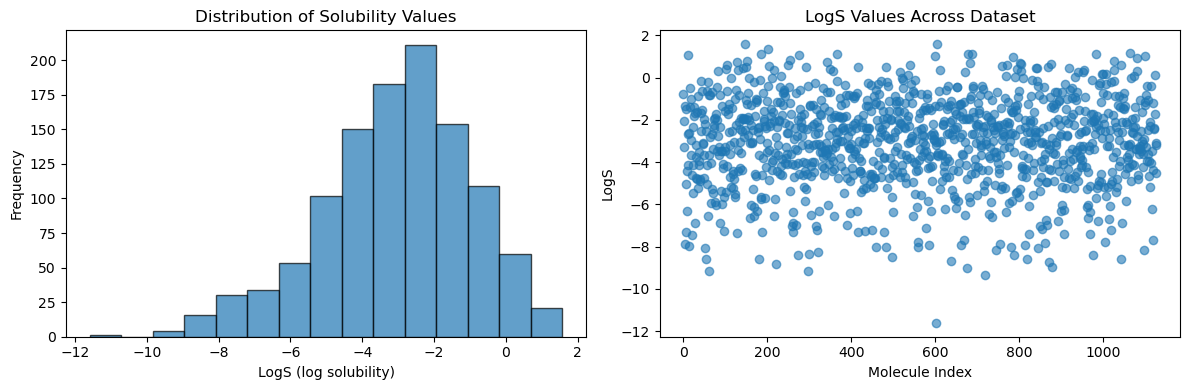

In [8]:

def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()
print(f"Dataset shape: {df.shape}")
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")
print("\nSample data:")
print(df.head())

# Visualize distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

Get LogP values of all molecules in dataset.

LogP range: -7.57 to 10.39


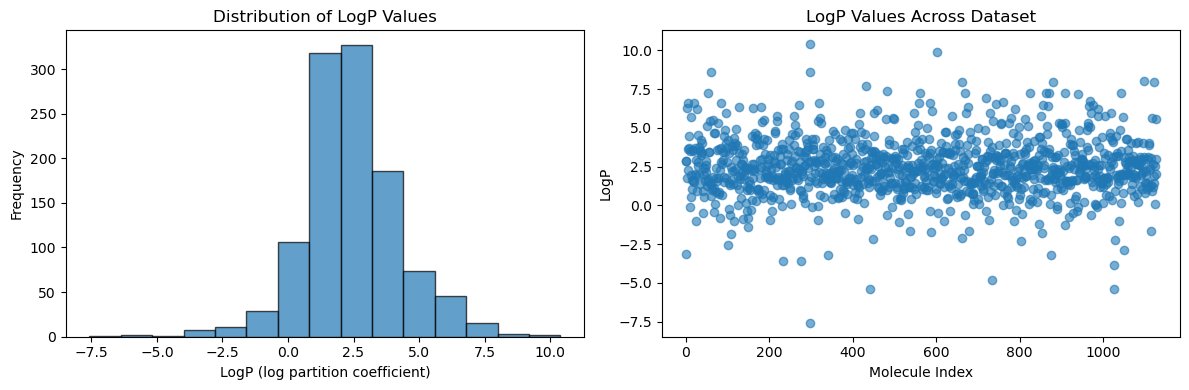

In [9]:
LogP =[]
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        logp = Crippen.MolLogP(mol)
        LogP.append(logp)
    else:
        LogP.append(np.nan)
df['LogP'] = LogP
print(f"LogP range: {df['LogP'].min():.2f} to {df['LogP'].max():.2f}")
# Visualize LogP distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogP (log partition coefficient)')
plt.ylabel('Frequency')
plt.title('Distribution of LogP Values')
plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogP')
plt.title('LogP Values Across Dataset')
plt.tight_layout()

Normalising target values (LogS and LogP)

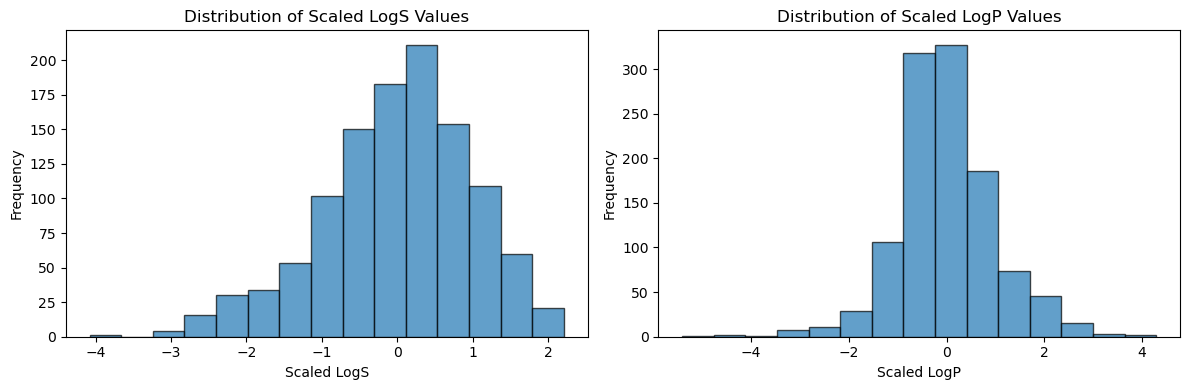

In [10]:
scaler_logS = StandardScaler()
df['logS_scaled'] = scaler_logS.fit_transform(df[['LogS']])
scaler_logP = StandardScaler()
df['logP_scaled'] = scaler_logP.fit_transform(df[['LogP']])
#Visualise scaled LogS and LogP
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['logS_scaled'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Scaled LogS')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled LogS Values')
plt.subplot(1, 2, 2)
plt.hist(df['logP_scaled'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Scaled LogP')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled LogP Values')
plt.tight_layout()

In [11]:
COMMON_ATOMS =set() #Atomic numbers of all atoms in dataset
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        COMMON_ATOMS.add(atom.GetAtomicNum())
COMMON_ATOMS.add(1) #Hydrogen is not explicitly present in mol.GetAtoms()
COMMON_ATOMS = sorted(list(COMMON_ATOMS))
print("Common atoms in ESOL dataset:", COMMON_ATOMS)

Common atoms in ESOL dataset: [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]


Some related helper functions for converting atom (vertices of our graph) to vector form from char form.


In [12]:

def one_hot_atomic_number(atomic_num):
    """Returns a one-hot encoded vector for the given atomic number."""
    idx = COMMON_ATOMS.index(atomic_num) if atomic_num in COMMON_ATOMS else len(COMMON_ATOMS)
    return F.one_hot(torch.tensor(idx), num_classes=len(COMMON_ATOMS) + 1).float()

def atom_features(atom):
    """Returns a feature vector for given 
    - consists of one-hot vector representing atom,degree of atom,formal charge,hybridisation and whether it is aromatic"""
    features = torch.cat([
        one_hot_atomic_number(atom.GetAtomicNum()),  # one-hot atomic number
        torch.tensor([
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization().real,
            atom.GetIsAromatic()
        ], dtype=torch.float)
    ])
    return features


Some helper functions to convert bonds (edges in our graph) to vector form

In [13]:
BOND_TYPES = [
    BondType.SINGLE,
    BondType.DOUBLE,
    BondType.TRIPLE,
    BondType.AROMATIC
] #list of different bond types(different types of edges in our graph)

def one_hot_bond_type(bond_type):
    """Returns a one hot encoded vector representing the bond type."""
    idx = BOND_TYPES.index(bond_type) if bond_type in BOND_TYPES else len(BOND_TYPES)
    return F.one_hot(torch.tensor(idx), num_classes=len(BOND_TYPES) + 1).float()

def bond_features(bond):
    """Returns a feture vector for bond - consisting of one-hot vector representing bond type, whether it is conjugated and whether it is in a ring."""
    features = torch.cat([
        one_hot_bond_type(bond.GetBondType()),  # one-hot bond type
        torch.tensor([
            bond.GetIsConjugated(),
            bond.IsInRing()
        ], dtype=torch.float)
    ])
    return features

print(bond_features(Chem.MolFromSmiles("CC=C").GetBondWithIdx(1)))

tensor([0., 1., 0., 0., 0., 0., 0.])


## Data Preprocessing

In this section, we convert our smiles data into graph form which we can give as input to our GNN.

In [14]:
def smiles_to_data(smiles, y):
    """Converts a SMILES string to a PyTorch Geometric Data object.
    In data object, x is node feature matrix , dimensions : [num_nodes, num_node_features]
    edge_index is a tensor of shape [2, num_edges] representing connectivity of the graph
    edge_attr is a tensor of shape [num_edges, num_edge_features] representing edge features
    y = target values (LogS and LogP in this case)"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # Edge features and connectivity
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        f = bond_features(bond)
        edge_index += [[i, j], [j, i]]
        edge_attr += [f, f]
    if not edge_attr:
      print(f"Skipping molecule with no bonds: {smiles}")
      return None
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    edge_attr = torch.stack(edge_attr)

    y = torch.tensor([y], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


In [15]:
def prepare_dataset(df):
    """function which returns a list of Data objects for each molecule in the dataframe."""
    data_list = []
    for _, row in df.iterrows():
        data = smiles_to_data(row['SMILES'], [row['logS_scaled'], row['logP_scaled']])
        if data:  # Skip invalid SMILES
            data_list.append(data)
    return data_list

In [16]:
data_list = prepare_dataset(df)
print(data_list[0]) 
loader = DataLoader(data_list, batch_size=32, shuffle=True)
train_set,test_set = random_split(data_list,[0.8 , 0.2])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

Skipping molecule with no bonds: C
Data(x=[32, 15], edge_index=[2, 68], edge_attr=[68, 7], y=[1, 2])


In [17]:
for batch in train_loader:
    print("Batch x shape:", batch.x.shape)  # Node features
    print("Batch edge_index shape:", batch.edge_index.shape)  # Edge connectivity
    print("Batch edge_attr shape:", batch.edge_attr.shape)  # Edge features
    print("Batch y shape:", batch.y.shape)  # Target values
    break  # Just show the first batch for brevity

Batch x shape: torch.Size([5, 15])
Batch edge_index shape: torch.Size([2, 8])
Batch edge_attr shape: torch.Size([8, 7])
Batch y shape: torch.Size([1, 2])


## Model definitions

Simple GNN for predicting LogS and LogP

Relevant hyperparameters : No Of convolutional layers,Number of neurons in fc_layers,hidden channels,dropout rate

Try experimenting with them and seeing the result

In [18]:
class SimpleGNN(nn.Module):
    """Graph Neural Network for predicting LogS and LogP from molecular graphs."""
    def __init__(self, num_node_features=15, num_edge_features=7, hidden_channels=64):
        super(SimpleGNN, self).__init__()

        # Edge-conditioned NN for conv1: outputs weights for 15 -> 64 transform
        nn1 = nn.Sequential(
            nn.Linear(num_edge_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_node_features * hidden_channels)  # 15 * 64
        )
        self.conv1 = NNConv(num_node_features, hidden_channels, nn1)

        # Edge-conditioned NN for conv2: 64 -> 32
        nn2 = nn.Sequential(
            nn.Linear(num_edge_features, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_channels * 32)
        )
        self.conv2 = NNConv(hidden_channels, 32, nn2)

        # Fully connected layers for regression
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, 2) 

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr))  # (N_nodes, 64)
        x = F.relu(self.conv2(x, edge_index, edge_attr))  # (N_nodes, 32)
        x = global_add_pool(x, batch)                     # (batch_size, 32)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)                                # (batch_size, 2) - predicting LogS and LogP


## MPNNs

MPNNs are basically a generalised form of GNNs.

Each node i has hidden state h_i_t at time t. At t = 0, h_i_0 = X_i (input vector).

In message-passing NNs, graph convolutions are divided into 2 phases - Message Passing phase and Update phase.

During message passing phase,information from other neighbouring nodes is passed to node. It is defined as : 

$$m_i = \sum_{j=1}^{N(i)} M_t(h_i^t,h_j^t,e_{ij})$$

where $m_i$ is message passed to node i, $M_t$ is message function, $h_i^t$ and $h_j^t$ are hidden states of nodes i and j respectively, and $e_{ij}$ is edge between nodes i and j and N(i) is set of neighbours of node i.

During update phase, hidden state of node i is updated as :

$$h_i^{t+1} = U_t(m_i,h_i^t)$$

where $U_t$ is update function.



## GCN Layer

First, we will implement a GCN layer using MPNN framework.

The GCN layer is defined as follows:

$$\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{i\}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left(\mathbf{W}^\top \cdot \mathbf{x}_j^{(k-1)}\right) + \mathbf{b},$$

In [19]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index,edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm,edge_attr=edge_attr)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

## MPNN Model using GCNConv layer

In [20]:
class MPNN_GCN(nn.Module):
    def __init__(self, num_node_features=15, num_edge_features=7, hidden_channels=64):
        super(MPNN_GCN, self).__init__()

        self.conv1 = GCNConv(num_node_features, hidden_channels)

        
        self.conv2 = GCNConv(hidden_channels, 32)
        # Fully connected layers for regression
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index,edge_attr))  # (N_nodes, 64)
        x = F.relu(self.conv2(x, edge_index,edge_attr))  # (N_nodes, 32)
        x = global_add_pool(x, batch)                     # (batch_size, 32)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)                                # (batch_size, 1)

## Edge Conv Layer

Now, we will implement an EdgeConv layer using MPNN framework. Although, this layer is mostly used for image segmentation and related tasks, we are using it now just to show different layers that can be implemented using Message Passing framework.

Edge conv layer is mathematically defined as follows:

$$\mathbf{x}_i^{(k)} = \max_{j \in \mathcal{N}(i)} h_{\Theta}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)} - \mathbf{x}_i^{(k-1)}\right)$$

Here, $h_{\Theta}$ is an MLP.

Moreover, edge conv also recomputes graph at each step by using a k-nn algorithm.

In [21]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') #  "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index,edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        return self.propagate(edge_index, x=x,edge_attr=edge_attr)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)
    
class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=6):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch,edge_index,edge_attr):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow) #recompute graph edges based on k-nearest neighbors
        return super().forward(x, edge_index,edge_attr=edge_attr)

## EdgeConv Layer MPNN Model

In [22]:
class MPNN_EdgeConv(nn.Module):
    def __init__(self, num_node_features=15, num_edge_features=7, hidden_channels=64):
        super(MPNN_EdgeConv, self).__init__()

        self.conv1 = DynamicEdgeConv(num_node_features, hidden_channels)

        
        self.conv2 = DynamicEdgeConv(hidden_channels, 32)
        # Fully connected layers for regression
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x,batch, edge_index,edge_attr))  # (N_nodes, 64)
        x = F.relu(self.conv2(x, batch,edge_index,edge_attr))  # (N_nodes, 32)
        x = global_add_pool(x, batch)                     # (batch_size, 32)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)   

In [23]:
os.makedirs('models', exist_ok=True)  # Create directory to save models if it doesn't 
results_dir = {} #dictionary to store results of each model

Function for training different models

In [24]:
def train_model(model,save_name, train_loader, test_loader,criterion,device,num_epochs = num_epochs,
                lr=learning_rate,patience = patience, min_delta = min_delta):
    """Function for training the model."""
    optimizer = Adam(model.parameters(), lr=lr)
    model.to(device)
    train_losses=[]
    train_losses_logs = []
    train_losses_logp = []
    test_losses=[]
    test_losses_logs = []
    test_losses_logp = []
    min_test_loss = float('inf')  # Initialize to a large value
    epochs_without_improvement = 0
    best_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loss_logs = 0
        train_loss_logp = 0
        for batch in tqdm(train_loader,desc = 'training set'):
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss_logs = criterion(pred[:, 0], batch.y[:, 0])  # LogS loss
            loss_logp = criterion(pred[:, 1], batch.y[:, 1])  # LogP loss
            loss = loss_logs + loss_logp
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loss_logs += loss_logs.item()
            train_loss_logp += loss_logp.item()
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f} | LogS Loss: {train_loss_logs / len(train_loader):.4f} | LogP Loss: {train_loss_logp / len(train_loader):.4f}")
        train_losses_logs.append(train_loss_logs / len(train_loader))
        train_losses_logp.append(train_loss_logp / len(train_loader))
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_loss_logs = 0
        test_loss_logp = 0
        with torch.no_grad():
            for batch in tqdm(test_loader,desc = 'testing set'):
                batch = batch.to(device)
                pred = model(batch)
                loss_logs = criterion(pred[:, 0], batch.y[:, 0]) # LogS loss
                loss_logp = criterion(pred[:, 1], batch.y[:, 1]) # LogP loss
                loss = loss_logs + loss_logp
                test_loss_logs += loss_logs.item()
                test_loss_logp += loss_logp.item()
                test_loss += loss.item()
        print(f"Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader):.4f} | LogS Loss: {test_loss_logs / len(test_loader):.4f} | LogP Loss: {test_loss_logp / len(test_loader):.4f}")
        test_losses.append(test_loss / len(test_loader))
        test_losses_logs.append(test_loss_logs / len(test_loader))
        test_losses_logp.append(test_loss_logp / len(test_loader))
        if((test_loss / len(test_loader)) < min_test_loss - min_delta):
            min_test_loss = (test_loss / len(test_loader))
            epochs_without_improvement =0
            best_epoch = epoch
            torch.save(model.state_dict(), f'models/{save_name}.pt')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > patience:
                print(f"Early stopping at epoch {epoch+1} with best epoch {best_epoch+1}")
                break
        
    return train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp

Function for plotting results of training process

In [25]:
def plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp):
    """
    Plot training results showing loss vs epoch for different loss components.
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot total losses
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Train Loss', marker='o', markersize=3)
    axes[0, 0].plot(epochs, test_losses, 'r-', label='Test Loss', marker='x', markersize=3)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Total Training and Test Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot LogS losses
    axes[0, 1].plot(epochs, train_losses_logs, 'b-', label='Train LogS Loss', marker='o', markersize=3)
    axes[0, 1].plot(epochs, test_losses_logs, 'r-', label='Test LogS Loss', marker='x', markersize=3)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('LogS Loss')
    axes[0, 1].set_title('LogS Training and Test Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot LogP losses
    axes[1, 0].plot(epochs, train_losses_logp, 'b-', label='Train LogP Loss', marker='o', markersize=3)
    axes[1, 0].plot(epochs, test_losses_logp, 'r-', label='Test LogP Loss', marker='x', markersize=3)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('LogP Loss')
    axes[1, 0].set_title('LogP Training and Test Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot comparison of all losses
    axes[1, 1].plot(epochs, train_losses, 'b-', label='Total Train', linewidth=2)
    axes[1, 1].plot(epochs, test_losses, 'r-', label='Total Test', linewidth=2)
    axes[1, 1].plot(epochs, train_losses_logs, 'b--', label='Train LogS', alpha=0.7)
    axes[1, 1].plot(epochs, test_losses_logs, 'r--', label='Test LogS', alpha=0.7)
    axes[1, 1].plot(epochs, train_losses_logp, 'b:', label='Train LogP', alpha=0.7)
    axes[1, 1].plot(epochs, test_losses_logp, 'r:', label='Test LogP', alpha=0.7)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('All Losses Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Function for showing results of best model

In [26]:
def evaluate_best_model(model, model_path, test_loader, device, scaler_logS=None, scaler_logP=None):
    """
    Evaluate the best saved model and create comprehensive plots and statistics.
    model_path: Path to the saved best model weights
    Plots predicted vs actual graphs for logS and logP and residual graph for logS and logP
    
    """
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Collect predictions and actual values
    preds_logs = []
    preds_logp = []
    actual_logs = []
    actual_logp = []
    total_loss = 0
    logs_loss = 0
    logp_loss = 0
    criterion = MSELoss()
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating best model'):
            batch = batch.to(device)
            pred = model(batch)
            
            # Extract LogS and LogP predictions and actuals
            pred_logs_batch = pred[:, 0].cpu().numpy()
            pred_logp_batch = pred[:, 1].cpu().numpy()
            actual_logs_batch = batch.y[:, 0].cpu().numpy()
            actual_logp_batch = batch.y[:, 1].cpu().numpy()
            
            preds_logs.extend(pred_logs_batch)
            preds_logp.extend(pred_logp_batch)
            actual_logs.extend(actual_logs_batch)
            actual_logp.extend(actual_logp_batch)
    
    # Convert to numpy arrays
    preds_logs = np.array(preds_logs)
    preds_logp = np.array(preds_logp)
    actual_logs = np.array(actual_logs)
    actual_logp = np.array(actual_logp)

    # Inverse transform if scalers are provided
    if scaler_logS is not None:
        preds_logs = scaler_logS.inverse_transform(preds_logs.reshape(-1, 1)).flatten()
        actual_logs = scaler_logS.inverse_transform(actual_logs.reshape(-1, 1)).flatten()
    
    if scaler_logP is not None:
        preds_logp = scaler_logP.inverse_transform(preds_logp.reshape(-1, 1)).flatten()
        actual_logp = scaler_logP.inverse_transform(actual_logp.reshape(-1, 1)).flatten()
    
    # Calculate metrics for LogS
    mse_logs = mean_squared_error(actual_logs, preds_logs)
    mae_logs = mean_absolute_error(actual_logs, preds_logs)
    r2_logs = r2_score(actual_logs, preds_logs)
    rmse_logs = np.sqrt(mse_logs)
    
    # Calculate metrics for LogP
    mse_logp = mean_squared_error(actual_logp, preds_logp)
    mae_logp = mean_absolute_error(actual_logp, preds_logp)
    r2_logp = r2_score(actual_logp, preds_logp)
    rmse_logp = np.sqrt(mse_logp)
    
    
    
    print("LogS PREDICTION METRICS:")
    print(f"  MSE:  {mse_logs:.4f}")
    print(f"  RMSE: {rmse_logs:.4f}")
    print(f"  MAE:  {mae_logs:.4f}")
    print(f"  R²:   {r2_logs:.4f}")
    print()
    
    print("LogP PREDICTION METRICS:")
    print(f"  MSE:  {mse_logp:.4f}")
    print(f"  RMSE: {rmse_logp:.4f}")
    print(f"  MAE:  {mae_logp:.4f}")
    print(f"  R²:   {r2_logp:.4f}")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: LogS True vs Predicted
    axes[0, 0].scatter(actual_logs, preds_logs, alpha=0.6, color='blue', s=20)
    min_val = min(min(actual_logs), min(preds_logs))
    max_val = max(max(actual_logs), max(preds_logs))
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('True LogS')
    axes[0, 0].set_ylabel('Predicted LogS')
    axes[0, 0].set_title(f'LogS: True vs Predicted (R² = {r2_logs:.3f})')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Plot 2: LogP True vs Predicted
    axes[0, 1].scatter(actual_logp, preds_logp, alpha=0.6, color='green', s=20)
    min_val = min(min(actual_logp), min(preds_logp))
    max_val = max(max(actual_logp), max(preds_logp))
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('True LogP')
    axes[0, 1].set_ylabel('Predicted LogP')
    axes[0, 1].set_title(f'LogP: True vs Predicted (R² = {r2_logp:.3f})')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Plot 3: Residuals vs Predicted for LogS
    residuals_logs = actual_logs - preds_logs
    axes[0, 2].scatter(preds_logs, residuals_logs, alpha=0.6, color='blue', s=20)
    axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Predicted LogS')
    axes[0, 2].set_ylabel('Residuals (True - Predicted)')
    axes[0, 2].set_title(f'LogS Residuals (MAE = {mae_logs:.3f})')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Residuals vs Predicted for LogP
    residuals_logp = actual_logp - preds_logp
    axes[1, 0].scatter(preds_logp, residuals_logp, alpha=0.6, color='green', s=20)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Predicted LogP')
    axes[1, 0].set_ylabel('Residuals (True - Predicted)')
    axes[1, 0].set_title(f'LogP Residuals (MAE = {mae_logp:.3f})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Distribution of residuals for LogS
    axes[1, 1].hist(residuals_logs, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'LogS Residuals Distribution (σ = {np.std(residuals_logs):.3f})')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Distribution of residuals for LogP
    axes[1, 2].hist(residuals_logp, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, 2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1, 2].set_xlabel('Residuals')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'LogP Residuals Distribution (σ = {np.std(residuals_logp):.3f})')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    return {
        "mae_logs": mae_logs,
        "mae_logp": mae_logp,
        "r2 logs": r2_logs,
        "r2 logp": r2_logp}
    
   
    
   

Training Simple GNN model

In [27]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGNN().to(device)
criterion = MSELoss()

train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp = train_model(
    model, 'gnn_model', train_loader, test_loader, criterion, device
)

training set: 100%|██████████| 902/902 [00:12<00:00, 73.77it/s] 


Epoch 1, Train Loss: 5.2131 | LogS Loss: 3.6155 | LogP Loss: 1.5976


testing set: 100%|██████████| 225/225 [00:00<00:00, 436.69it/s]


Epoch 1, Test Loss: 1.4604 | LogS Loss: 0.8243 | LogP Loss: 0.6360


training set: 100%|██████████| 902/902 [00:12<00:00, 70.73it/s] 


Epoch 2, Train Loss: 1.6323 | LogS Loss: 0.8355 | LogP Loss: 0.7969


testing set: 100%|██████████| 225/225 [00:01<00:00, 120.99it/s]


Epoch 2, Test Loss: 1.9497 | LogS Loss: 1.0356 | LogP Loss: 0.9142


training set: 100%|██████████| 902/902 [00:13<00:00, 65.53it/s] 


Epoch 3, Train Loss: 1.5284 | LogS Loss: 0.7875 | LogP Loss: 0.7409


testing set: 100%|██████████| 225/225 [00:00<00:00, 579.38it/s]


Epoch 3, Test Loss: 1.3812 | LogS Loss: 0.7460 | LogP Loss: 0.6353


training set: 100%|██████████| 902/902 [00:03<00:00, 245.27it/s]


Epoch 4, Train Loss: 1.3068 | LogS Loss: 0.7010 | LogP Loss: 0.6058


testing set: 100%|██████████| 225/225 [00:00<00:00, 598.38it/s]


Epoch 4, Test Loss: 1.2500 | LogS Loss: 0.6925 | LogP Loss: 0.5575


training set: 100%|██████████| 902/902 [00:03<00:00, 231.88it/s]


Epoch 5, Train Loss: 1.2850 | LogS Loss: 0.6861 | LogP Loss: 0.5989


testing set: 100%|██████████| 225/225 [00:00<00:00, 561.58it/s]


Epoch 5, Test Loss: 1.1822 | LogS Loss: 0.6337 | LogP Loss: 0.5485


training set: 100%|██████████| 902/902 [00:04<00:00, 216.08it/s]


Epoch 6, Train Loss: 1.2871 | LogS Loss: 0.6666 | LogP Loss: 0.6204


testing set: 100%|██████████| 225/225 [00:00<00:00, 586.67it/s]


Epoch 6, Test Loss: 1.3628 | LogS Loss: 0.6563 | LogP Loss: 0.7065


training set: 100%|██████████| 902/902 [00:04<00:00, 181.50it/s]


Epoch 7, Train Loss: 1.2516 | LogS Loss: 0.6683 | LogP Loss: 0.5833


testing set: 100%|██████████| 225/225 [00:00<00:00, 500.97it/s]


Epoch 7, Test Loss: 1.4549 | LogS Loss: 0.7714 | LogP Loss: 0.6835


training set: 100%|██████████| 902/902 [00:04<00:00, 185.52it/s]


Epoch 8, Train Loss: 1.2151 | LogS Loss: 0.6537 | LogP Loss: 0.5614


testing set: 100%|██████████| 225/225 [00:00<00:00, 512.77it/s]


Epoch 8, Test Loss: 1.3136 | LogS Loss: 0.7176 | LogP Loss: 0.5960


training set: 100%|██████████| 902/902 [00:04<00:00, 199.72it/s]


Epoch 9, Train Loss: 1.1115 | LogS Loss: 0.5919 | LogP Loss: 0.5196


testing set: 100%|██████████| 225/225 [00:00<00:00, 477.38it/s]


Epoch 9, Test Loss: 1.3384 | LogS Loss: 0.7005 | LogP Loss: 0.6380


training set: 100%|██████████| 902/902 [00:04<00:00, 210.87it/s]


Epoch 10, Train Loss: 1.1554 | LogS Loss: 0.6039 | LogP Loss: 0.5515


testing set: 100%|██████████| 225/225 [00:00<00:00, 498.51it/s]


Epoch 10, Test Loss: 0.9732 | LogS Loss: 0.5311 | LogP Loss: 0.4421


training set: 100%|██████████| 902/902 [00:04<00:00, 206.43it/s]


Epoch 11, Train Loss: 1.0482 | LogS Loss: 0.5550 | LogP Loss: 0.4932


testing set: 100%|██████████| 225/225 [00:00<00:00, 502.64it/s]


Epoch 11, Test Loss: 1.0351 | LogS Loss: 0.5600 | LogP Loss: 0.4751


training set: 100%|██████████| 902/902 [00:04<00:00, 204.93it/s]


Epoch 12, Train Loss: 1.0197 | LogS Loss: 0.5449 | LogP Loss: 0.4749


testing set: 100%|██████████| 225/225 [00:00<00:00, 428.61it/s]


Epoch 12, Test Loss: 0.9354 | LogS Loss: 0.4977 | LogP Loss: 0.4377


training set: 100%|██████████| 902/902 [00:05<00:00, 161.38it/s]


Epoch 13, Train Loss: 1.0018 | LogS Loss: 0.5256 | LogP Loss: 0.4763


testing set: 100%|██████████| 225/225 [00:00<00:00, 544.67it/s]


Epoch 13, Test Loss: 0.9875 | LogS Loss: 0.5039 | LogP Loss: 0.4836


training set: 100%|██████████| 902/902 [00:04<00:00, 207.22it/s]


Epoch 14, Train Loss: 0.9870 | LogS Loss: 0.5131 | LogP Loss: 0.4740


testing set: 100%|██████████| 225/225 [00:00<00:00, 524.28it/s]


Epoch 14, Test Loss: 1.0316 | LogS Loss: 0.5675 | LogP Loss: 0.4641


training set: 100%|██████████| 902/902 [00:04<00:00, 202.11it/s]


Epoch 15, Train Loss: 0.9569 | LogS Loss: 0.4922 | LogP Loss: 0.4647


testing set: 100%|██████████| 225/225 [00:00<00:00, 517.16it/s]


Epoch 15, Test Loss: 0.9603 | LogS Loss: 0.4946 | LogP Loss: 0.4657


training set: 100%|██████████| 902/902 [00:04<00:00, 191.82it/s]


Epoch 16, Train Loss: 0.9166 | LogS Loss: 0.4650 | LogP Loss: 0.4516


testing set: 100%|██████████| 225/225 [00:00<00:00, 476.37it/s]


Epoch 16, Test Loss: 0.8772 | LogS Loss: 0.4748 | LogP Loss: 0.4024


training set: 100%|██████████| 902/902 [00:04<00:00, 207.44it/s]


Epoch 17, Train Loss: 0.9088 | LogS Loss: 0.4663 | LogP Loss: 0.4425


testing set: 100%|██████████| 225/225 [00:00<00:00, 519.85it/s]


Epoch 17, Test Loss: 1.4348 | LogS Loss: 0.7922 | LogP Loss: 0.6426


training set: 100%|██████████| 902/902 [00:04<00:00, 201.92it/s]


Epoch 18, Train Loss: 0.9121 | LogS Loss: 0.4676 | LogP Loss: 0.4445


testing set: 100%|██████████| 225/225 [00:00<00:00, 445.91it/s]


Epoch 18, Test Loss: 0.9472 | LogS Loss: 0.4883 | LogP Loss: 0.4589


training set: 100%|██████████| 902/902 [00:04<00:00, 199.86it/s]


Epoch 19, Train Loss: 0.8882 | LogS Loss: 0.4557 | LogP Loss: 0.4325


testing set: 100%|██████████| 225/225 [00:00<00:00, 551.94it/s]


Epoch 19, Test Loss: 0.8999 | LogS Loss: 0.4720 | LogP Loss: 0.4279


training set: 100%|██████████| 902/902 [00:04<00:00, 210.37it/s]


Epoch 20, Train Loss: 0.8731 | LogS Loss: 0.4392 | LogP Loss: 0.4339


testing set: 100%|██████████| 225/225 [00:00<00:00, 552.89it/s]


Epoch 20, Test Loss: 0.8289 | LogS Loss: 0.4323 | LogP Loss: 0.3966


training set: 100%|██████████| 902/902 [00:04<00:00, 224.88it/s]


Epoch 21, Train Loss: 0.8817 | LogS Loss: 0.4498 | LogP Loss: 0.4320


testing set: 100%|██████████| 225/225 [00:00<00:00, 576.11it/s]


Epoch 21, Test Loss: 0.8189 | LogS Loss: 0.4174 | LogP Loss: 0.4015


training set: 100%|██████████| 902/902 [00:04<00:00, 220.45it/s]


Epoch 22, Train Loss: 0.6641 | LogS Loss: 0.3452 | LogP Loss: 0.3189


testing set: 100%|██████████| 225/225 [00:00<00:00, 486.67it/s]


Epoch 22, Test Loss: 0.5893 | LogS Loss: 0.3194 | LogP Loss: 0.2699


training set: 100%|██████████| 902/902 [00:04<00:00, 196.44it/s]


Epoch 23, Train Loss: 0.6374 | LogS Loss: 0.3362 | LogP Loss: 0.3013


testing set: 100%|██████████| 225/225 [00:00<00:00, 510.26it/s]


Epoch 23, Test Loss: 0.4965 | LogS Loss: 0.2586 | LogP Loss: 0.2380


training set: 100%|██████████| 902/902 [00:04<00:00, 207.36it/s]


Epoch 24, Train Loss: 0.5322 | LogS Loss: 0.2893 | LogP Loss: 0.2429


testing set: 100%|██████████| 225/225 [00:00<00:00, 556.00it/s]


Epoch 24, Test Loss: 0.6861 | LogS Loss: 0.3496 | LogP Loss: 0.3365


training set: 100%|██████████| 902/902 [00:04<00:00, 212.72it/s]


Epoch 25, Train Loss: 0.4811 | LogS Loss: 0.2605 | LogP Loss: 0.2206


testing set: 100%|██████████| 225/225 [00:00<00:00, 504.57it/s]


Epoch 25, Test Loss: 0.4296 | LogS Loss: 0.2507 | LogP Loss: 0.1789


training set: 100%|██████████| 902/902 [00:04<00:00, 213.06it/s]


Epoch 26, Train Loss: 0.4007 | LogS Loss: 0.2289 | LogP Loss: 0.1718


testing set: 100%|██████████| 225/225 [00:00<00:00, 557.58it/s]


Epoch 26, Test Loss: 0.4787 | LogS Loss: 0.3089 | LogP Loss: 0.1698


training set: 100%|██████████| 902/902 [00:04<00:00, 200.78it/s]


Epoch 27, Train Loss: 0.4027 | LogS Loss: 0.2436 | LogP Loss: 0.1591


testing set: 100%|██████████| 225/225 [00:00<00:00, 593.76it/s]


Epoch 27, Test Loss: 0.3767 | LogS Loss: 0.2416 | LogP Loss: 0.1352


training set: 100%|██████████| 902/902 [00:04<00:00, 195.11it/s]


Epoch 28, Train Loss: 0.5176 | LogS Loss: 0.3025 | LogP Loss: 0.2151


testing set: 100%|██████████| 225/225 [00:00<00:00, 391.25it/s]


Epoch 28, Test Loss: 0.4629 | LogS Loss: 0.2626 | LogP Loss: 0.2003


training set: 100%|██████████| 902/902 [00:04<00:00, 210.80it/s]


Epoch 29, Train Loss: 0.3911 | LogS Loss: 0.2357 | LogP Loss: 0.1555


testing set: 100%|██████████| 225/225 [00:00<00:00, 443.47it/s]


Epoch 29, Test Loss: 0.3717 | LogS Loss: 0.2329 | LogP Loss: 0.1388


training set: 100%|██████████| 902/902 [00:04<00:00, 202.51it/s]


Epoch 30, Train Loss: 0.3269 | LogS Loss: 0.2073 | LogP Loss: 0.1196


testing set: 100%|██████████| 225/225 [00:00<00:00, 596.59it/s]


Epoch 30, Test Loss: 0.3849 | LogS Loss: 0.2118 | LogP Loss: 0.1731


training set: 100%|██████████| 902/902 [00:04<00:00, 194.49it/s]


Epoch 31, Train Loss: 0.3067 | LogS Loss: 0.1961 | LogP Loss: 0.1106


testing set: 100%|██████████| 225/225 [00:00<00:00, 608.10it/s]


Epoch 31, Test Loss: 0.2818 | LogS Loss: 0.1903 | LogP Loss: 0.0915


training set: 100%|██████████| 902/902 [00:03<00:00, 259.30it/s]


Epoch 32, Train Loss: 0.2829 | LogS Loss: 0.1850 | LogP Loss: 0.0979


testing set: 100%|██████████| 225/225 [00:00<00:00, 550.46it/s]


Epoch 32, Test Loss: 0.4094 | LogS Loss: 0.2569 | LogP Loss: 0.1525


training set: 100%|██████████| 902/902 [00:03<00:00, 226.32it/s]


Epoch 33, Train Loss: 0.2778 | LogS Loss: 0.1769 | LogP Loss: 0.1009


testing set: 100%|██████████| 225/225 [00:00<00:00, 616.14it/s]


Epoch 33, Test Loss: 0.3133 | LogS Loss: 0.2204 | LogP Loss: 0.0930


training set: 100%|██████████| 902/902 [00:03<00:00, 261.08it/s]


Epoch 34, Train Loss: 0.3354 | LogS Loss: 0.2175 | LogP Loss: 0.1179


testing set: 100%|██████████| 225/225 [00:00<00:00, 579.81it/s]


Epoch 34, Test Loss: 0.2927 | LogS Loss: 0.2049 | LogP Loss: 0.0878


training set: 100%|██████████| 902/902 [00:03<00:00, 246.02it/s]


Epoch 35, Train Loss: 0.2862 | LogS Loss: 0.1795 | LogP Loss: 0.1067


testing set: 100%|██████████| 225/225 [00:00<00:00, 575.05it/s]


Epoch 35, Test Loss: 0.2295 | LogS Loss: 0.1554 | LogP Loss: 0.0741


training set: 100%|██████████| 902/902 [00:03<00:00, 240.31it/s]


Epoch 36, Train Loss: 0.2601 | LogS Loss: 0.1642 | LogP Loss: 0.0960


testing set: 100%|██████████| 225/225 [00:00<00:00, 567.82it/s]


Epoch 36, Test Loss: 0.2496 | LogS Loss: 0.1701 | LogP Loss: 0.0794


training set: 100%|██████████| 902/902 [00:03<00:00, 227.16it/s]


Epoch 37, Train Loss: 0.2859 | LogS Loss: 0.1794 | LogP Loss: 0.1065


testing set: 100%|██████████| 225/225 [00:00<00:00, 421.76it/s]


Epoch 37, Test Loss: 0.2649 | LogS Loss: 0.1732 | LogP Loss: 0.0916


training set: 100%|██████████| 902/902 [00:16<00:00, 54.61it/s] 


Epoch 38, Train Loss: 0.2635 | LogS Loss: 0.1630 | LogP Loss: 0.1005


testing set: 100%|██████████| 225/225 [00:01<00:00, 150.35it/s]


Epoch 38, Test Loss: 0.4578 | LogS Loss: 0.2631 | LogP Loss: 0.1947


training set: 100%|██████████| 902/902 [00:08<00:00, 111.01it/s]


Epoch 39, Train Loss: 0.2699 | LogS Loss: 0.1675 | LogP Loss: 0.1024


testing set: 100%|██████████| 225/225 [00:00<00:00, 300.35it/s]


Epoch 39, Test Loss: 0.2603 | LogS Loss: 0.1669 | LogP Loss: 0.0934


training set: 100%|██████████| 902/902 [00:06<00:00, 144.60it/s]


Epoch 40, Train Loss: 0.2347 | LogS Loss: 0.1526 | LogP Loss: 0.0821


testing set: 100%|██████████| 225/225 [00:00<00:00, 300.89it/s]


Epoch 40, Test Loss: 0.2731 | LogS Loss: 0.1827 | LogP Loss: 0.0903


training set: 100%|██████████| 902/902 [00:06<00:00, 149.55it/s]


Epoch 41, Train Loss: 0.2458 | LogS Loss: 0.1620 | LogP Loss: 0.0838


testing set: 100%|██████████| 225/225 [00:00<00:00, 340.99it/s]


Epoch 41, Test Loss: 0.2552 | LogS Loss: 0.1831 | LogP Loss: 0.0721


training set: 100%|██████████| 902/902 [00:06<00:00, 141.49it/s]


Epoch 42, Train Loss: 0.2363 | LogS Loss: 0.1501 | LogP Loss: 0.0862


testing set: 100%|██████████| 225/225 [00:00<00:00, 321.76it/s]


Epoch 42, Test Loss: 0.3439 | LogS Loss: 0.2495 | LogP Loss: 0.0943


training set: 100%|██████████| 902/902 [00:06<00:00, 137.25it/s]


Epoch 43, Train Loss: 0.2828 | LogS Loss: 0.1811 | LogP Loss: 0.1017


testing set: 100%|██████████| 225/225 [00:00<00:00, 326.68it/s]


Epoch 43, Test Loss: 0.2708 | LogS Loss: 0.1633 | LogP Loss: 0.1076


training set: 100%|██████████| 902/902 [00:06<00:00, 137.37it/s]


Epoch 44, Train Loss: 0.2404 | LogS Loss: 0.1595 | LogP Loss: 0.0808


testing set: 100%|██████████| 225/225 [00:00<00:00, 331.58it/s]


Epoch 44, Test Loss: 0.2396 | LogS Loss: 0.1666 | LogP Loss: 0.0730


training set: 100%|██████████| 902/902 [00:06<00:00, 137.50it/s]


Epoch 45, Train Loss: 0.2322 | LogS Loss: 0.1507 | LogP Loss: 0.0815


testing set: 100%|██████████| 225/225 [00:00<00:00, 336.75it/s]


Epoch 45, Test Loss: 0.2575 | LogS Loss: 0.1967 | LogP Loss: 0.0608


training set: 100%|██████████| 902/902 [00:06<00:00, 140.69it/s]


Epoch 46, Train Loss: 0.2390 | LogS Loss: 0.1496 | LogP Loss: 0.0895


testing set: 100%|██████████| 225/225 [00:00<00:00, 336.35it/s]


Epoch 46, Test Loss: 0.2370 | LogS Loss: 0.1671 | LogP Loss: 0.0698
Early stopping at epoch 46 with best epoch 35


Plot results for SimpleGNN

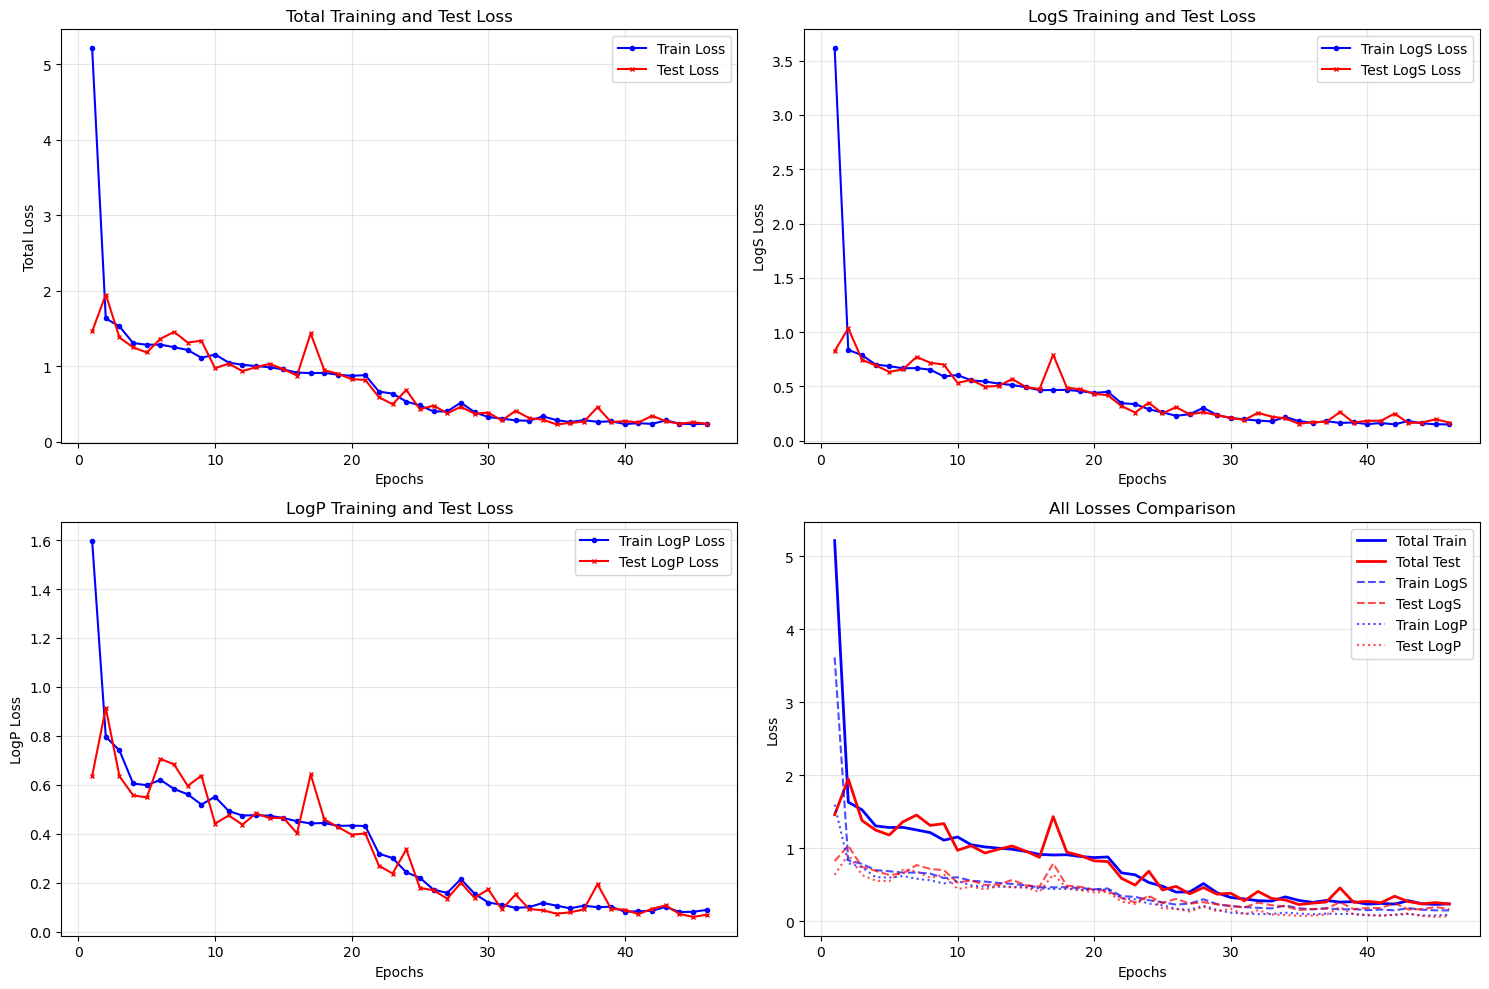

Evaluating best model: 100%|██████████| 225/225 [00:00<00:00, 265.91it/s]


LogS PREDICTION METRICS:
  MSE:  0.6824
  RMSE: 0.8261
  MAE:  0.6407
  R²:   0.8583

LogP PREDICTION METRICS:
  MSE:  0.2541
  RMSE: 0.5041
  MAE:  0.3590
  R²:   0.9287


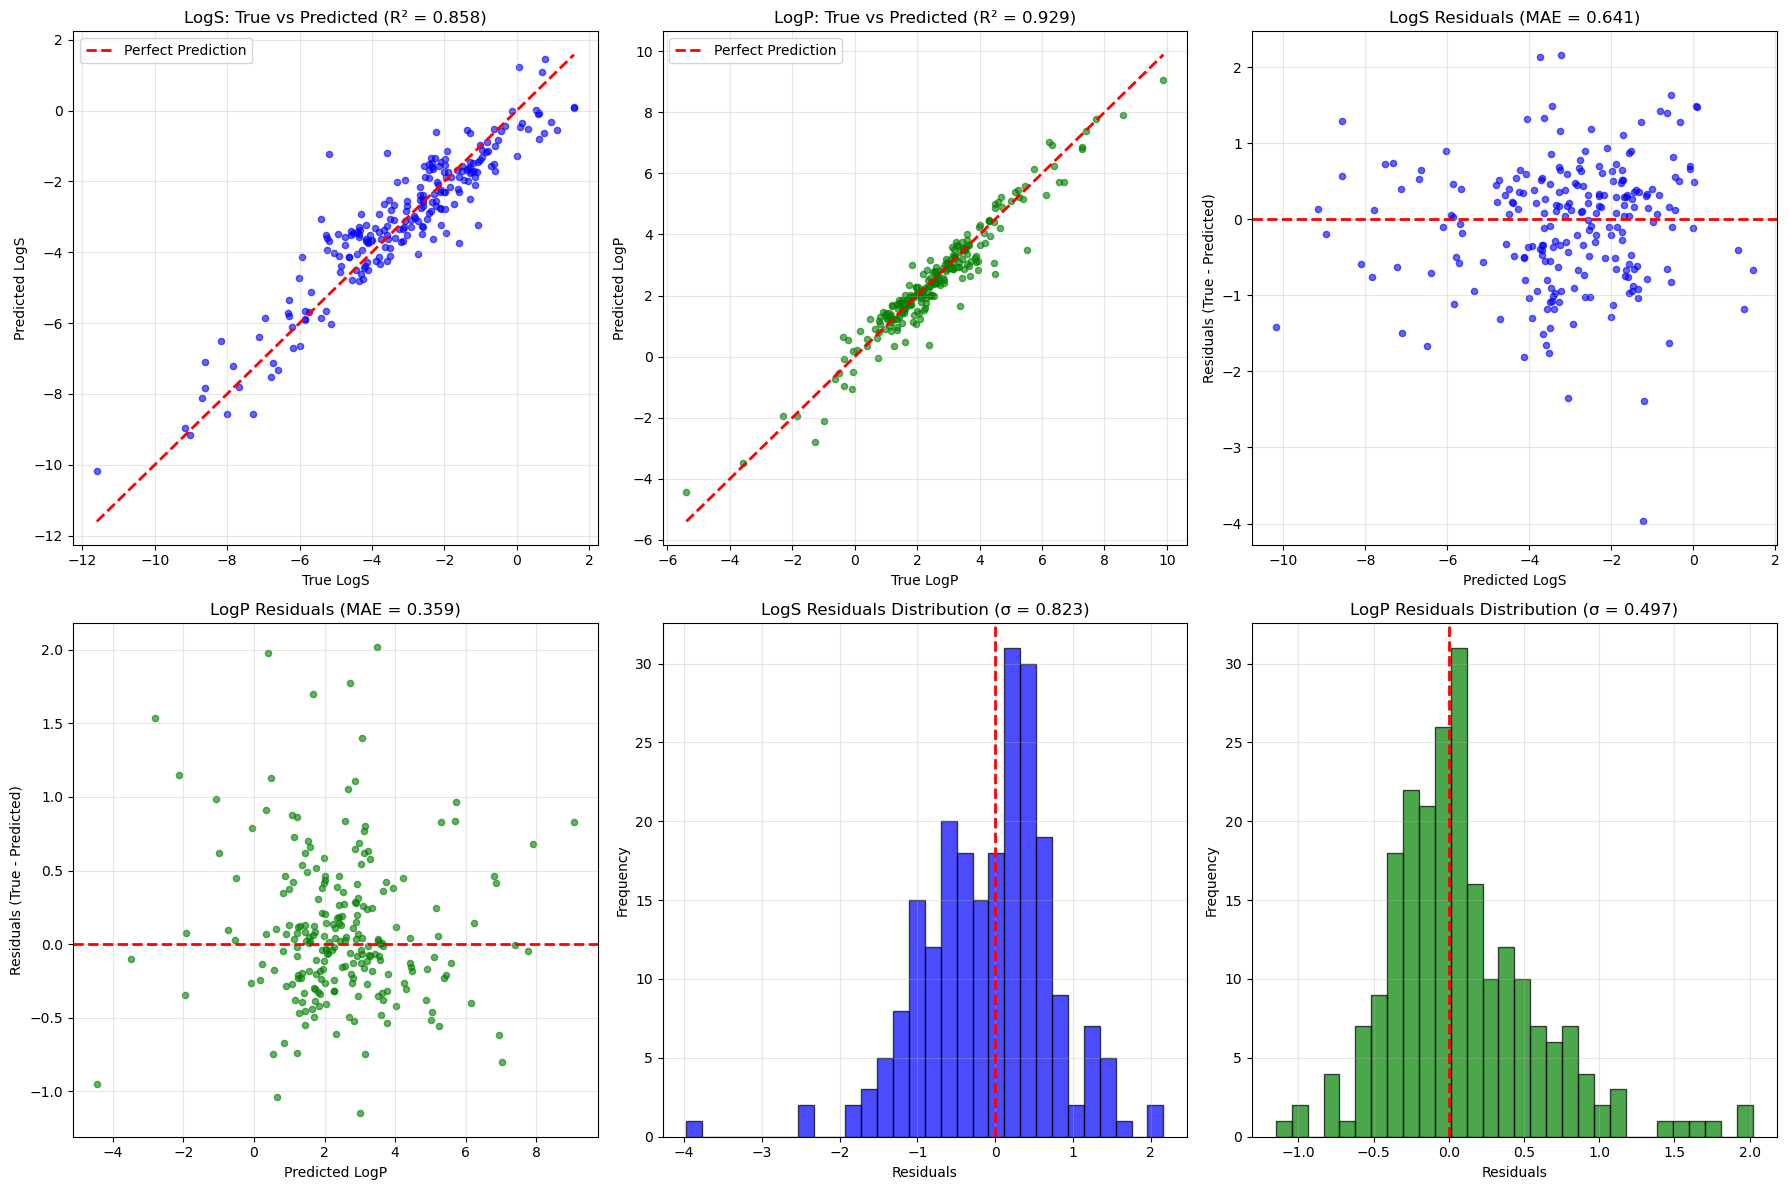

In [28]:
# Plot the results
plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp)
# Evaluate the best model
result_dict=evaluate_best_model(model, 'models/gnn_model.pt', test_loader, device, scaler_logS=scaler_logS, scaler_logP=scaler_logP)
results_dir['simplegnn'] = result_dict

## Training MPNN_GCN model

In [29]:
model = MPNN_GCN().to(device)
model.to(device)
train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp = train_model(
    model, 'mpnn_gcn_model', train_loader, test_loader, criterion, device
)

training set: 100%|██████████| 902/902 [00:05<00:00, 172.18it/s]


Epoch 1, Train Loss: 1.6503 | LogS Loss: 0.7719 | LogP Loss: 0.8784


testing set: 100%|██████████| 225/225 [00:00<00:00, 297.51it/s]


Epoch 1, Test Loss: 0.9444 | LogS Loss: 0.4841 | LogP Loss: 0.4603


training set: 100%|██████████| 902/902 [00:05<00:00, 177.81it/s]


Epoch 2, Train Loss: 0.8023 | LogS Loss: 0.4259 | LogP Loss: 0.3764


testing set: 100%|██████████| 225/225 [00:00<00:00, 293.91it/s]


Epoch 2, Test Loss: 0.4760 | LogS Loss: 0.2864 | LogP Loss: 0.1895


training set: 100%|██████████| 902/902 [00:05<00:00, 178.49it/s]


Epoch 3, Train Loss: 0.5070 | LogS Loss: 0.2951 | LogP Loss: 0.2119


testing set: 100%|██████████| 225/225 [00:00<00:00, 289.98it/s]


Epoch 3, Test Loss: 0.2853 | LogS Loss: 0.1985 | LogP Loss: 0.0868


training set: 100%|██████████| 902/902 [00:05<00:00, 178.66it/s]


Epoch 4, Train Loss: 0.3823 | LogS Loss: 0.2377 | LogP Loss: 0.1446


testing set: 100%|██████████| 225/225 [00:00<00:00, 299.06it/s]


Epoch 4, Test Loss: 0.2840 | LogS Loss: 0.1871 | LogP Loss: 0.0969


training set: 100%|██████████| 902/902 [00:08<00:00, 108.05it/s]


Epoch 5, Train Loss: 0.3998 | LogS Loss: 0.2374 | LogP Loss: 0.1624


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.56it/s]


Epoch 5, Test Loss: 0.2901 | LogS Loss: 0.1925 | LogP Loss: 0.0976


training set: 100%|██████████| 902/902 [00:12<00:00, 72.48it/s]


Epoch 6, Train Loss: 0.3382 | LogS Loss: 0.2200 | LogP Loss: 0.1182


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.40it/s]


Epoch 6, Test Loss: 0.4714 | LogS Loss: 0.2899 | LogP Loss: 0.1815


training set: 100%|██████████| 902/902 [00:12<00:00, 71.64it/s]


Epoch 7, Train Loss: 0.3690 | LogS Loss: 0.2223 | LogP Loss: 0.1467


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.95it/s]


Epoch 7, Test Loss: 0.2943 | LogS Loss: 0.2115 | LogP Loss: 0.0827


training set: 100%|██████████| 902/902 [00:12<00:00, 71.89it/s]


Epoch 8, Train Loss: 0.3527 | LogS Loss: 0.2231 | LogP Loss: 0.1297


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.67it/s]


Epoch 8, Test Loss: 0.3013 | LogS Loss: 0.1950 | LogP Loss: 0.1062


training set: 100%|██████████| 902/902 [00:12<00:00, 71.67it/s]


Epoch 9, Train Loss: 0.3069 | LogS Loss: 0.1973 | LogP Loss: 0.1097


testing set: 100%|██████████| 225/225 [00:01<00:00, 119.57it/s]


Epoch 9, Test Loss: 0.2656 | LogS Loss: 0.1802 | LogP Loss: 0.0853


training set: 100%|██████████| 902/902 [00:12<00:00, 71.98it/s]


Epoch 10, Train Loss: 0.3005 | LogS Loss: 0.1996 | LogP Loss: 0.1010


testing set: 100%|██████████| 225/225 [00:02<00:00, 109.87it/s]


Epoch 10, Test Loss: 0.3304 | LogS Loss: 0.1924 | LogP Loss: 0.1380


training set: 100%|██████████| 902/902 [00:12<00:00, 70.32it/s]


Epoch 11, Train Loss: 0.3101 | LogS Loss: 0.1956 | LogP Loss: 0.1144


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.79it/s]


Epoch 11, Test Loss: 0.4745 | LogS Loss: 0.2774 | LogP Loss: 0.1971


training set: 100%|██████████| 902/902 [00:12<00:00, 70.39it/s]


Epoch 12, Train Loss: 0.2846 | LogS Loss: 0.1822 | LogP Loss: 0.1024


testing set: 100%|██████████| 225/225 [00:01<00:00, 122.87it/s]


Epoch 12, Test Loss: 0.2259 | LogS Loss: 0.1484 | LogP Loss: 0.0775


training set: 100%|██████████| 902/902 [00:12<00:00, 72.34it/s]


Epoch 13, Train Loss: 0.2642 | LogS Loss: 0.1729 | LogP Loss: 0.0913


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.54it/s]


Epoch 13, Test Loss: 0.2450 | LogS Loss: 0.1544 | LogP Loss: 0.0906


training set: 100%|██████████| 902/902 [00:12<00:00, 71.92it/s]


Epoch 14, Train Loss: 0.2817 | LogS Loss: 0.1836 | LogP Loss: 0.0981


testing set: 100%|██████████| 225/225 [00:01<00:00, 121.91it/s]


Epoch 14, Test Loss: 0.2676 | LogS Loss: 0.1621 | LogP Loss: 0.1055


training set: 100%|██████████| 902/902 [00:12<00:00, 70.51it/s]


Epoch 15, Train Loss: 0.2448 | LogS Loss: 0.1639 | LogP Loss: 0.0809


testing set: 100%|██████████| 225/225 [00:01<00:00, 120.46it/s]


Epoch 15, Test Loss: 0.2607 | LogS Loss: 0.1526 | LogP Loss: 0.1081


training set: 100%|██████████| 902/902 [00:12<00:00, 71.03it/s]


Epoch 16, Train Loss: 0.2518 | LogS Loss: 0.1712 | LogP Loss: 0.0806


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.03it/s]


Epoch 16, Test Loss: 0.2020 | LogS Loss: 0.1467 | LogP Loss: 0.0554


training set: 100%|██████████| 902/902 [00:12<00:00, 69.98it/s]


Epoch 17, Train Loss: 0.2382 | LogS Loss: 0.1629 | LogP Loss: 0.0753


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.93it/s]


Epoch 17, Test Loss: 0.1723 | LogS Loss: 0.1362 | LogP Loss: 0.0362


training set: 100%|██████████| 902/902 [00:13<00:00, 68.28it/s]


Epoch 18, Train Loss: 0.2380 | LogS Loss: 0.1659 | LogP Loss: 0.0721


testing set: 100%|██████████| 225/225 [00:02<00:00, 111.78it/s]


Epoch 18, Test Loss: 0.3511 | LogS Loss: 0.2150 | LogP Loss: 0.1361


training set: 100%|██████████| 902/902 [00:12<00:00, 69.70it/s]


Epoch 19, Train Loss: 0.2546 | LogS Loss: 0.1653 | LogP Loss: 0.0893


testing set: 100%|██████████| 225/225 [00:01<00:00, 113.16it/s]


Epoch 19, Test Loss: 0.2564 | LogS Loss: 0.1386 | LogP Loss: 0.1178


training set: 100%|██████████| 902/902 [00:12<00:00, 69.43it/s]


Epoch 20, Train Loss: 0.2343 | LogS Loss: 0.1522 | LogP Loss: 0.0821


testing set: 100%|██████████| 225/225 [00:01<00:00, 113.19it/s]


Epoch 20, Test Loss: 0.1698 | LogS Loss: 0.1195 | LogP Loss: 0.0503


training set: 100%|██████████| 902/902 [00:12<00:00, 70.88it/s]


Epoch 21, Train Loss: 0.2246 | LogS Loss: 0.1527 | LogP Loss: 0.0719


testing set: 100%|██████████| 225/225 [00:02<00:00, 112.24it/s]


Epoch 21, Test Loss: 0.1574 | LogS Loss: 0.1138 | LogP Loss: 0.0435


training set: 100%|██████████| 902/902 [00:12<00:00, 70.14it/s]


Epoch 22, Train Loss: 0.2348 | LogS Loss: 0.1467 | LogP Loss: 0.0880


testing set: 100%|██████████| 225/225 [00:02<00:00, 110.65it/s]


Epoch 22, Test Loss: 0.1670 | LogS Loss: 0.1168 | LogP Loss: 0.0502


training set: 100%|██████████| 902/902 [00:12<00:00, 70.35it/s]


Epoch 23, Train Loss: 0.2314 | LogS Loss: 0.1614 | LogP Loss: 0.0700


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.30it/s]


Epoch 23, Test Loss: 0.1639 | LogS Loss: 0.1255 | LogP Loss: 0.0384


training set: 100%|██████████| 902/902 [00:12<00:00, 71.05it/s]


Epoch 24, Train Loss: 0.2174 | LogS Loss: 0.1449 | LogP Loss: 0.0725


testing set: 100%|██████████| 225/225 [00:02<00:00, 111.75it/s]


Epoch 24, Test Loss: 0.1757 | LogS Loss: 0.1093 | LogP Loss: 0.0664


training set: 100%|██████████| 902/902 [00:12<00:00, 71.81it/s]


Epoch 25, Train Loss: 0.2381 | LogS Loss: 0.1489 | LogP Loss: 0.0892


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.35it/s]


Epoch 25, Test Loss: 0.1702 | LogS Loss: 0.1264 | LogP Loss: 0.0438


training set: 100%|██████████| 902/902 [00:12<00:00, 71.45it/s]


Epoch 26, Train Loss: 0.2143 | LogS Loss: 0.1434 | LogP Loss: 0.0708


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.37it/s]


Epoch 26, Test Loss: 0.1447 | LogS Loss: 0.1118 | LogP Loss: 0.0329


training set: 100%|██████████| 902/902 [00:12<00:00, 71.46it/s]


Epoch 27, Train Loss: 0.2003 | LogS Loss: 0.1344 | LogP Loss: 0.0660


testing set: 100%|██████████| 225/225 [00:01<00:00, 113.70it/s]


Epoch 27, Test Loss: 0.1583 | LogS Loss: 0.1214 | LogP Loss: 0.0369


training set: 100%|██████████| 902/902 [00:12<00:00, 69.84it/s]


Epoch 28, Train Loss: 0.1993 | LogS Loss: 0.1415 | LogP Loss: 0.0578


testing set: 100%|██████████| 225/225 [00:02<00:00, 109.82it/s]


Epoch 28, Test Loss: 0.1533 | LogS Loss: 0.1119 | LogP Loss: 0.0414


training set: 100%|██████████| 902/902 [00:12<00:00, 70.84it/s]


Epoch 29, Train Loss: 0.2208 | LogS Loss: 0.1461 | LogP Loss: 0.0747


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.47it/s]


Epoch 29, Test Loss: 0.2098 | LogS Loss: 0.1269 | LogP Loss: 0.0830


training set: 100%|██████████| 902/902 [00:12<00:00, 70.91it/s]


Epoch 30, Train Loss: 0.2150 | LogS Loss: 0.1408 | LogP Loss: 0.0742


testing set: 100%|██████████| 225/225 [00:01<00:00, 112.83it/s]


Epoch 30, Test Loss: 0.1352 | LogS Loss: 0.1075 | LogP Loss: 0.0277


training set: 100%|██████████| 902/902 [00:12<00:00, 70.02it/s]


Epoch 31, Train Loss: 0.1896 | LogS Loss: 0.1370 | LogP Loss: 0.0526


testing set: 100%|██████████| 225/225 [00:02<00:00, 109.88it/s]


Epoch 31, Test Loss: 0.1791 | LogS Loss: 0.1500 | LogP Loss: 0.0291


training set: 100%|██████████| 902/902 [00:12<00:00, 69.46it/s]


Epoch 32, Train Loss: 0.2252 | LogS Loss: 0.1539 | LogP Loss: 0.0713


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.27it/s]


Epoch 32, Test Loss: 0.1555 | LogS Loss: 0.1262 | LogP Loss: 0.0292


training set: 100%|██████████| 902/902 [00:12<00:00, 70.13it/s]


Epoch 33, Train Loss: 0.1959 | LogS Loss: 0.1331 | LogP Loss: 0.0628


testing set: 100%|██████████| 225/225 [00:02<00:00, 107.09it/s]


Epoch 33, Test Loss: 0.1987 | LogS Loss: 0.1516 | LogP Loss: 0.0470


training set: 100%|██████████| 902/902 [00:13<00:00, 68.28it/s]


Epoch 34, Train Loss: 0.2167 | LogS Loss: 0.1507 | LogP Loss: 0.0660


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.22it/s]


Epoch 34, Test Loss: 0.1628 | LogS Loss: 0.1255 | LogP Loss: 0.0373


training set: 100%|██████████| 902/902 [00:12<00:00, 70.15it/s]


Epoch 35, Train Loss: 0.1997 | LogS Loss: 0.1384 | LogP Loss: 0.0614


testing set: 100%|██████████| 225/225 [00:02<00:00, 112.00it/s]


Epoch 35, Test Loss: 0.1309 | LogS Loss: 0.0974 | LogP Loss: 0.0335


training set: 100%|██████████| 902/902 [00:13<00:00, 69.22it/s]


Epoch 36, Train Loss: 0.1920 | LogS Loss: 0.1312 | LogP Loss: 0.0608


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.68it/s]


Epoch 36, Test Loss: 0.1600 | LogS Loss: 0.1126 | LogP Loss: 0.0474


training set: 100%|██████████| 902/902 [00:12<00:00, 72.04it/s]


Epoch 37, Train Loss: 0.1867 | LogS Loss: 0.1301 | LogP Loss: 0.0565


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.69it/s]


Epoch 37, Test Loss: 0.1424 | LogS Loss: 0.1147 | LogP Loss: 0.0277


training set: 100%|██████████| 902/902 [00:12<00:00, 72.11it/s]


Epoch 38, Train Loss: 0.1970 | LogS Loss: 0.1348 | LogP Loss: 0.0621


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.47it/s]


Epoch 38, Test Loss: 0.1733 | LogS Loss: 0.1339 | LogP Loss: 0.0394


training set: 100%|██████████| 902/902 [00:12<00:00, 71.90it/s]


Epoch 39, Train Loss: 0.1774 | LogS Loss: 0.1227 | LogP Loss: 0.0547


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.94it/s]


Epoch 39, Test Loss: 0.1525 | LogS Loss: 0.1130 | LogP Loss: 0.0395


training set: 100%|██████████| 902/902 [00:12<00:00, 70.80it/s]


Epoch 40, Train Loss: 0.1992 | LogS Loss: 0.1395 | LogP Loss: 0.0597


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.60it/s]


Epoch 40, Test Loss: 0.1766 | LogS Loss: 0.1242 | LogP Loss: 0.0524


training set: 100%|██████████| 902/902 [00:12<00:00, 72.64it/s]


Epoch 41, Train Loss: 0.2143 | LogS Loss: 0.1429 | LogP Loss: 0.0714


testing set: 100%|██████████| 225/225 [00:01<00:00, 119.58it/s]


Epoch 41, Test Loss: 0.1556 | LogS Loss: 0.1246 | LogP Loss: 0.0311


training set: 100%|██████████| 902/902 [00:12<00:00, 72.25it/s]


Epoch 42, Train Loss: 0.1848 | LogS Loss: 0.1261 | LogP Loss: 0.0586


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.38it/s]


Epoch 42, Test Loss: 0.2142 | LogS Loss: 0.1344 | LogP Loss: 0.0797


training set: 100%|██████████| 902/902 [00:12<00:00, 70.37it/s]


Epoch 43, Train Loss: 0.1866 | LogS Loss: 0.1259 | LogP Loss: 0.0607


testing set: 100%|██████████| 225/225 [00:02<00:00, 111.45it/s]


Epoch 43, Test Loss: 0.1368 | LogS Loss: 0.1083 | LogP Loss: 0.0284


training set: 100%|██████████| 902/902 [00:12<00:00, 69.61it/s]


Epoch 44, Train Loss: 0.2041 | LogS Loss: 0.1451 | LogP Loss: 0.0591


testing set: 100%|██████████| 225/225 [00:01<00:00, 114.21it/s]


Epoch 44, Test Loss: 0.1713 | LogS Loss: 0.1198 | LogP Loss: 0.0515


training set: 100%|██████████| 902/902 [00:12<00:00, 70.50it/s]


Epoch 45, Train Loss: 0.1831 | LogS Loss: 0.1278 | LogP Loss: 0.0554


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.32it/s]


Epoch 45, Test Loss: 0.1673 | LogS Loss: 0.1038 | LogP Loss: 0.0635


training set: 100%|██████████| 902/902 [00:12<00:00, 70.89it/s]


Epoch 46, Train Loss: 0.1838 | LogS Loss: 0.1303 | LogP Loss: 0.0535


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.77it/s]


Epoch 46, Test Loss: 0.1228 | LogS Loss: 0.0967 | LogP Loss: 0.0261


training set: 100%|██████████| 902/902 [00:12<00:00, 71.21it/s]


Epoch 47, Train Loss: 0.1629 | LogS Loss: 0.1143 | LogP Loss: 0.0486


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.53it/s]


Epoch 47, Test Loss: 0.1504 | LogS Loss: 0.0988 | LogP Loss: 0.0517


training set: 100%|██████████| 902/902 [00:12<00:00, 72.08it/s]


Epoch 48, Train Loss: 0.1756 | LogS Loss: 0.1260 | LogP Loss: 0.0495


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.16it/s]


Epoch 48, Test Loss: 0.1505 | LogS Loss: 0.1066 | LogP Loss: 0.0439


training set: 100%|██████████| 902/902 [00:12<00:00, 70.34it/s]


Epoch 49, Train Loss: 0.1827 | LogS Loss: 0.1221 | LogP Loss: 0.0606


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.22it/s]


Epoch 49, Test Loss: 0.2383 | LogS Loss: 0.1290 | LogP Loss: 0.1093


training set: 100%|██████████| 902/902 [00:12<00:00, 70.40it/s]


Epoch 50, Train Loss: 0.2039 | LogS Loss: 0.1363 | LogP Loss: 0.0676


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.56it/s]


Epoch 50, Test Loss: 0.1907 | LogS Loss: 0.1410 | LogP Loss: 0.0497


training set: 100%|██████████| 902/902 [00:12<00:00, 69.81it/s]


Epoch 51, Train Loss: 0.1721 | LogS Loss: 0.1205 | LogP Loss: 0.0516


testing set: 100%|██████████| 225/225 [00:01<00:00, 112.91it/s]


Epoch 51, Test Loss: 0.1488 | LogS Loss: 0.1073 | LogP Loss: 0.0415


training set: 100%|██████████| 902/902 [00:12<00:00, 70.40it/s]


Epoch 52, Train Loss: 0.1644 | LogS Loss: 0.1165 | LogP Loss: 0.0479


testing set: 100%|██████████| 225/225 [00:02<00:00, 107.25it/s]


Epoch 52, Test Loss: 0.1223 | LogS Loss: 0.0983 | LogP Loss: 0.0240


training set: 100%|██████████| 902/902 [00:13<00:00, 69.16it/s]


Epoch 53, Train Loss: 0.1733 | LogS Loss: 0.1126 | LogP Loss: 0.0607


testing set: 100%|██████████| 225/225 [00:02<00:00, 111.52it/s]


Epoch 53, Test Loss: 0.1172 | LogS Loss: 0.0931 | LogP Loss: 0.0241


training set: 100%|██████████| 902/902 [00:12<00:00, 70.91it/s]


Epoch 54, Train Loss: 0.1796 | LogS Loss: 0.1195 | LogP Loss: 0.0601


testing set: 100%|██████████| 225/225 [00:01<00:00, 114.63it/s]


Epoch 54, Test Loss: 0.1571 | LogS Loss: 0.1122 | LogP Loss: 0.0449


training set: 100%|██████████| 902/902 [00:12<00:00, 70.70it/s]


Epoch 55, Train Loss: 0.1937 | LogS Loss: 0.1323 | LogP Loss: 0.0614


testing set: 100%|██████████| 225/225 [00:01<00:00, 114.58it/s]


Epoch 55, Test Loss: 0.1526 | LogS Loss: 0.1139 | LogP Loss: 0.0387


training set: 100%|██████████| 902/902 [00:12<00:00, 71.09it/s]


Epoch 56, Train Loss: 0.1767 | LogS Loss: 0.1188 | LogP Loss: 0.0579


testing set: 100%|██████████| 225/225 [00:01<00:00, 112.99it/s]


Epoch 56, Test Loss: 0.1922 | LogS Loss: 0.1128 | LogP Loss: 0.0793


training set: 100%|██████████| 902/902 [00:12<00:00, 71.04it/s]


Epoch 57, Train Loss: 0.1681 | LogS Loss: 0.1149 | LogP Loss: 0.0532


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.16it/s]


Epoch 57, Test Loss: 0.1993 | LogS Loss: 0.1246 | LogP Loss: 0.0746


training set: 100%|██████████| 902/902 [00:12<00:00, 71.25it/s]


Epoch 58, Train Loss: 0.1625 | LogS Loss: 0.1133 | LogP Loss: 0.0491


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.92it/s]


Epoch 58, Test Loss: 0.1464 | LogS Loss: 0.1081 | LogP Loss: 0.0383


training set: 100%|██████████| 902/902 [00:12<00:00, 70.94it/s]


Epoch 59, Train Loss: 0.1699 | LogS Loss: 0.1185 | LogP Loss: 0.0515


testing set: 100%|██████████| 225/225 [00:01<00:00, 115.76it/s]


Epoch 59, Test Loss: 0.1323 | LogS Loss: 0.1022 | LogP Loss: 0.0300


training set: 100%|██████████| 902/902 [00:12<00:00, 71.03it/s]


Epoch 60, Train Loss: 0.1670 | LogS Loss: 0.1184 | LogP Loss: 0.0486


testing set: 100%|██████████| 225/225 [00:01<00:00, 116.44it/s]


Epoch 60, Test Loss: 0.1179 | LogS Loss: 0.0943 | LogP Loss: 0.0237


training set: 100%|██████████| 902/902 [00:12<00:00, 70.70it/s]


Epoch 61, Train Loss: 0.1771 | LogS Loss: 0.1199 | LogP Loss: 0.0572


testing set: 100%|██████████| 225/225 [00:01<00:00, 118.41it/s]


Epoch 61, Test Loss: 0.1573 | LogS Loss: 0.0998 | LogP Loss: 0.0575


training set: 100%|██████████| 902/902 [00:12<00:00, 71.52it/s]


Epoch 62, Train Loss: 0.1779 | LogS Loss: 0.1209 | LogP Loss: 0.0570


testing set: 100%|██████████| 225/225 [00:01<00:00, 117.07it/s]


Epoch 62, Test Loss: 0.1390 | LogS Loss: 0.1059 | LogP Loss: 0.0331


training set: 100%|██████████| 902/902 [00:12<00:00, 70.91it/s]


Epoch 63, Train Loss: 0.1673 | LogS Loss: 0.1158 | LogP Loss: 0.0515


testing set: 100%|██████████| 225/225 [00:01<00:00, 119.06it/s]


Epoch 63, Test Loss: 0.1483 | LogS Loss: 0.1068 | LogP Loss: 0.0415


training set: 100%|██████████| 902/902 [00:12<00:00, 71.53it/s]


Epoch 64, Train Loss: 0.1709 | LogS Loss: 0.1201 | LogP Loss: 0.0507


testing set: 100%|██████████| 225/225 [00:01<00:00, 114.50it/s]

Epoch 64, Test Loss: 0.2449 | LogS Loss: 0.1422 | LogP Loss: 0.1027
Early stopping at epoch 64 with best epoch 53


## Plotting and storing Results

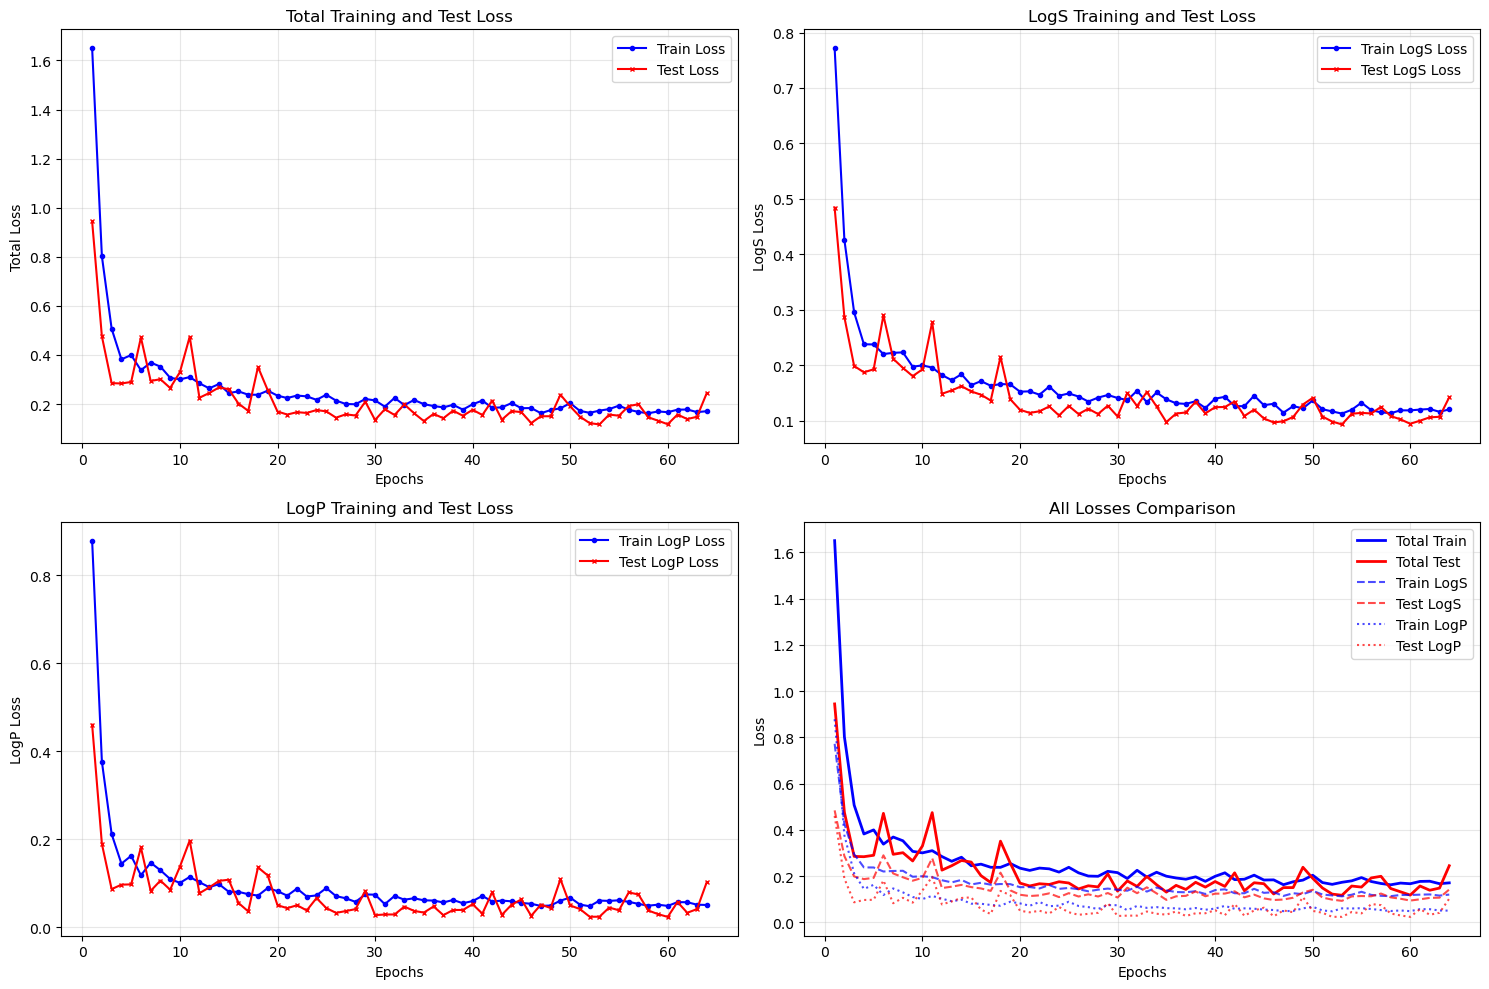

Evaluating best model: 100%|██████████| 225/225 [00:01<00:00, 117.29it/s]


LogS PREDICTION METRICS:
  MSE:  0.4089
  RMSE: 0.6394
  MAE:  0.5138
  R²:   0.9151

LogP PREDICTION METRICS:
  MSE:  0.0825
  RMSE: 0.2873
  MAE:  0.2013
  R²:   0.9768


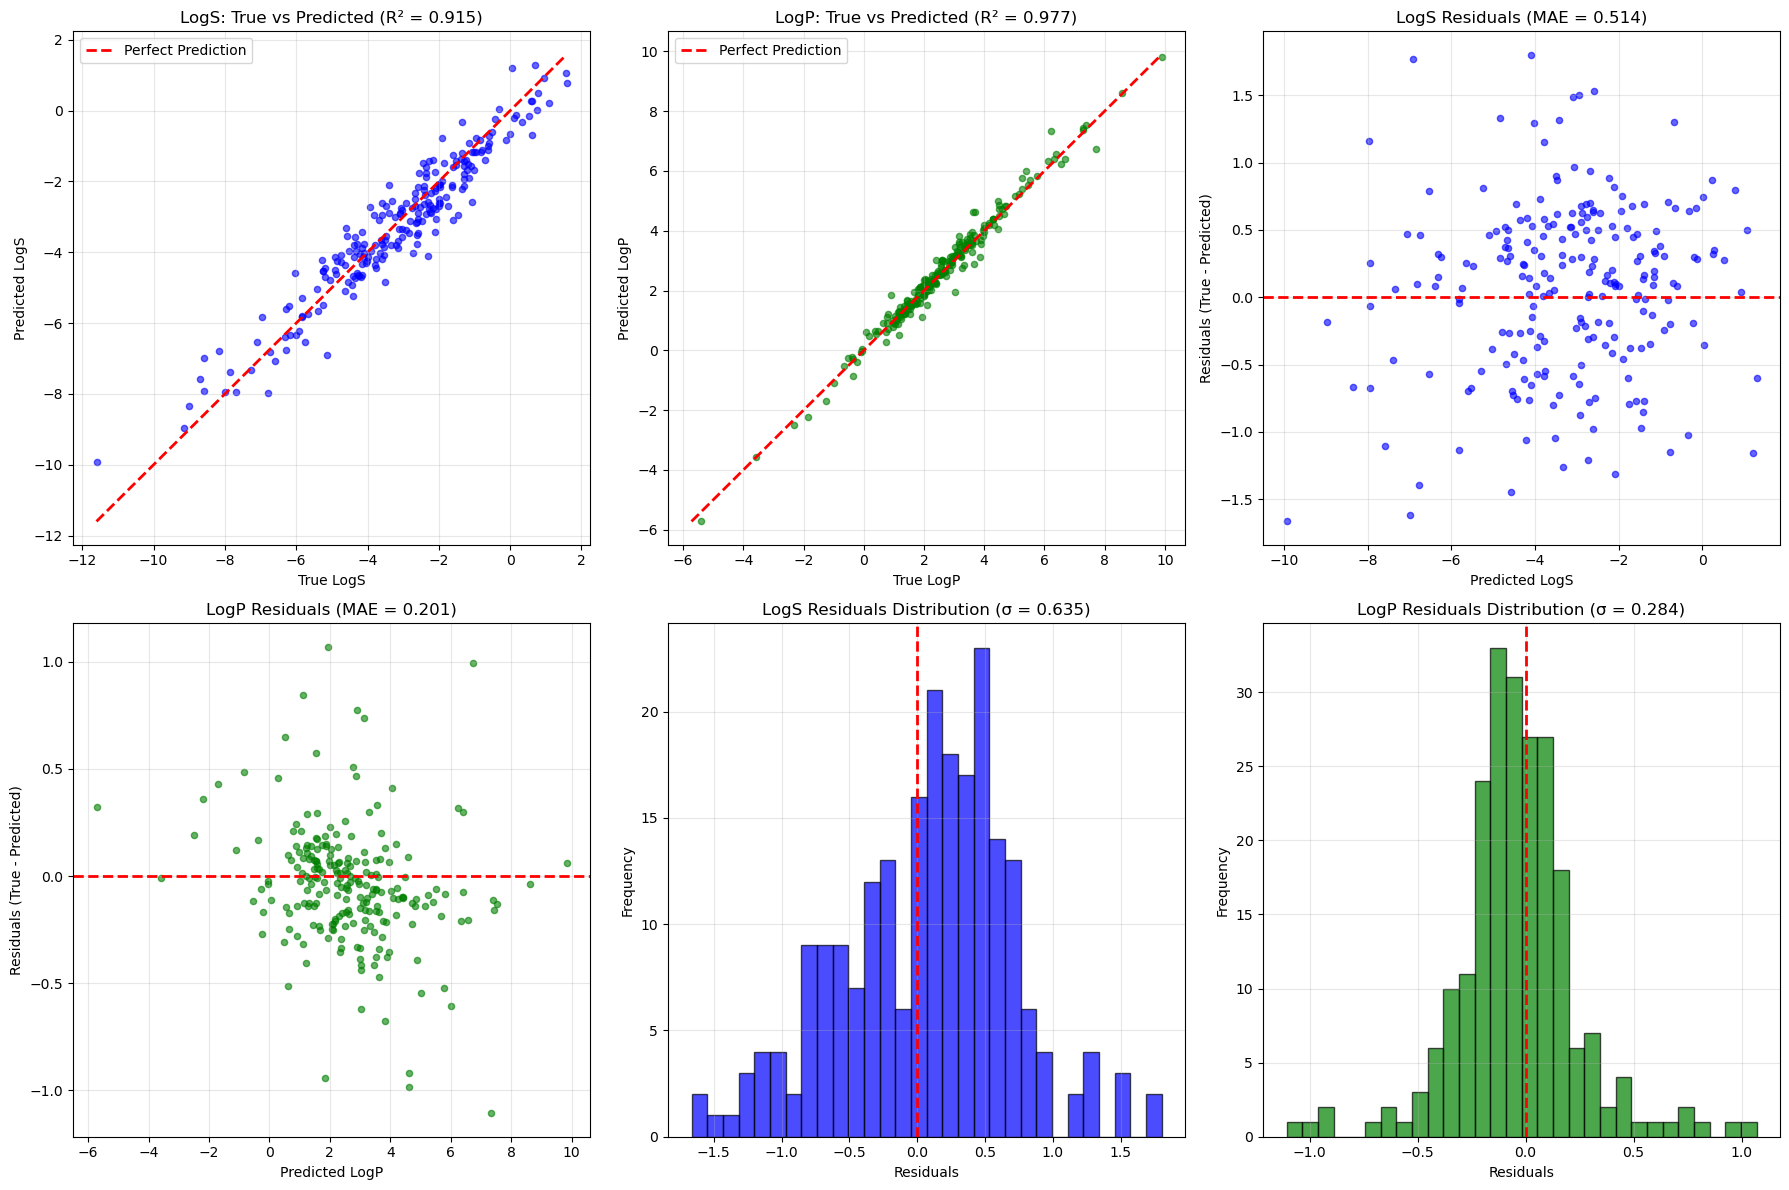

In [30]:
# Plot the results
plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp)
# Evaluate the best model
result_dict=evaluate_best_model(model, 'models/mpnn_gcn_model.pt', test_loader, device, scaler_logS=scaler_logS, scaler_logP=scaler_logP)
results_dir['mpnn_gcn'] = result_dict

## Training MPNN EdgeConv Model

In [31]:
model = MPNN_EdgeConv().to(device)
model.to(device)
train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp = train_model(
    model, 'mpnn_edgeconv_model', train_loader, test_loader, criterion, device
)

training set: 100%|██████████| 902/902 [00:16<00:00, 53.27it/s]


Epoch 1, Train Loss: 1.3132 | LogS Loss: 0.6199 | LogP Loss: 0.6933


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.06it/s]


Epoch 1, Test Loss: 0.8630 | LogS Loss: 0.4841 | LogP Loss: 0.3789


training set: 100%|██████████| 902/902 [00:16<00:00, 53.28it/s]


Epoch 2, Train Loss: 0.6575 | LogS Loss: 0.3564 | LogP Loss: 0.3012


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.13it/s]


Epoch 2, Test Loss: 0.3960 | LogS Loss: 0.2299 | LogP Loss: 0.1660


training set: 100%|██████████| 902/902 [00:16<00:00, 53.29it/s]


Epoch 3, Train Loss: 0.4145 | LogS Loss: 0.2565 | LogP Loss: 0.1580


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.94it/s]


Epoch 3, Test Loss: 0.3192 | LogS Loss: 0.2188 | LogP Loss: 0.1004


training set: 100%|██████████| 902/902 [00:16<00:00, 54.64it/s]


Epoch 4, Train Loss: 0.3609 | LogS Loss: 0.2182 | LogP Loss: 0.1427


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.38it/s]


Epoch 4, Test Loss: 0.3078 | LogS Loss: 0.1925 | LogP Loss: 0.1153


training set: 100%|██████████| 902/902 [00:16<00:00, 54.47it/s]


Epoch 5, Train Loss: 0.3333 | LogS Loss: 0.2113 | LogP Loss: 0.1220


testing set: 100%|██████████| 225/225 [00:02<00:00, 76.11it/s]


Epoch 5, Test Loss: 0.2706 | LogS Loss: 0.1766 | LogP Loss: 0.0940


training set: 100%|██████████| 902/902 [00:16<00:00, 54.51it/s]


Epoch 6, Train Loss: 0.2910 | LogS Loss: 0.1908 | LogP Loss: 0.1002


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.18it/s]


Epoch 6, Test Loss: 0.2762 | LogS Loss: 0.1853 | LogP Loss: 0.0909


training set: 100%|██████████| 902/902 [00:16<00:00, 53.66it/s]


Epoch 7, Train Loss: 0.3023 | LogS Loss: 0.1872 | LogP Loss: 0.1151


testing set: 100%|██████████| 225/225 [00:02<00:00, 79.69it/s]


Epoch 7, Test Loss: 0.2166 | LogS Loss: 0.1468 | LogP Loss: 0.0698


training set: 100%|██████████| 902/902 [00:16<00:00, 53.98it/s]


Epoch 8, Train Loss: 0.2687 | LogS Loss: 0.1786 | LogP Loss: 0.0901


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.69it/s]


Epoch 8, Test Loss: 0.2454 | LogS Loss: 0.1669 | LogP Loss: 0.0785


training set: 100%|██████████| 902/902 [00:17<00:00, 52.62it/s]


Epoch 9, Train Loss: 0.2322 | LogS Loss: 0.1570 | LogP Loss: 0.0752


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.14it/s]


Epoch 9, Test Loss: 0.2890 | LogS Loss: 0.1920 | LogP Loss: 0.0970


training set: 100%|██████████| 902/902 [00:16<00:00, 53.17it/s]


Epoch 10, Train Loss: 0.2678 | LogS Loss: 0.1730 | LogP Loss: 0.0948


testing set: 100%|██████████| 225/225 [00:02<00:00, 81.42it/s]


Epoch 10, Test Loss: 0.3073 | LogS Loss: 0.1887 | LogP Loss: 0.1186


training set: 100%|██████████| 902/902 [00:16<00:00, 53.35it/s]


Epoch 11, Train Loss: 0.2607 | LogS Loss: 0.1630 | LogP Loss: 0.0977


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.47it/s]


Epoch 11, Test Loss: 0.2158 | LogS Loss: 0.1379 | LogP Loss: 0.0779


training set: 100%|██████████| 902/902 [00:16<00:00, 54.05it/s]


Epoch 12, Train Loss: 0.2353 | LogS Loss: 0.1550 | LogP Loss: 0.0803


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.20it/s]


Epoch 12, Test Loss: 0.1830 | LogS Loss: 0.1326 | LogP Loss: 0.0504


training set: 100%|██████████| 902/902 [00:16<00:00, 53.10it/s]


Epoch 13, Train Loss: 0.2276 | LogS Loss: 0.1532 | LogP Loss: 0.0744


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.66it/s]


Epoch 13, Test Loss: 0.1913 | LogS Loss: 0.1292 | LogP Loss: 0.0621


training set: 100%|██████████| 902/902 [00:17<00:00, 53.05it/s]


Epoch 14, Train Loss: 0.2252 | LogS Loss: 0.1484 | LogP Loss: 0.0768


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.18it/s]


Epoch 14, Test Loss: 0.1758 | LogS Loss: 0.1318 | LogP Loss: 0.0440


training set: 100%|██████████| 902/902 [00:17<00:00, 52.98it/s]


Epoch 15, Train Loss: 0.2449 | LogS Loss: 0.1547 | LogP Loss: 0.0903


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.62it/s]


Epoch 15, Test Loss: 0.1886 | LogS Loss: 0.1205 | LogP Loss: 0.0681


training set: 100%|██████████| 902/902 [00:17<00:00, 52.29it/s]


Epoch 16, Train Loss: 0.2167 | LogS Loss: 0.1426 | LogP Loss: 0.0741


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.58it/s]


Epoch 16, Test Loss: 0.2033 | LogS Loss: 0.1356 | LogP Loss: 0.0677


training set: 100%|██████████| 902/902 [00:16<00:00, 53.86it/s]


Epoch 17, Train Loss: 0.1976 | LogS Loss: 0.1343 | LogP Loss: 0.0633


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.34it/s]


Epoch 17, Test Loss: 0.2050 | LogS Loss: 0.1374 | LogP Loss: 0.0675


training set: 100%|██████████| 902/902 [00:16<00:00, 54.36it/s]


Epoch 18, Train Loss: 0.2057 | LogS Loss: 0.1295 | LogP Loss: 0.0762


testing set: 100%|██████████| 225/225 [00:02<00:00, 86.66it/s]


Epoch 18, Test Loss: 0.1822 | LogS Loss: 0.1308 | LogP Loss: 0.0514


training set: 100%|██████████| 902/902 [00:17<00:00, 53.02it/s]


Epoch 19, Train Loss: 0.2109 | LogS Loss: 0.1467 | LogP Loss: 0.0642


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.72it/s]


Epoch 19, Test Loss: 0.2166 | LogS Loss: 0.1343 | LogP Loss: 0.0823


training set: 100%|██████████| 902/902 [00:16<00:00, 53.31it/s]


Epoch 20, Train Loss: 0.2275 | LogS Loss: 0.1377 | LogP Loss: 0.0898


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.85it/s]


Epoch 20, Test Loss: 0.1869 | LogS Loss: 0.1297 | LogP Loss: 0.0572


training set: 100%|██████████| 902/902 [00:17<00:00, 52.83it/s]


Epoch 21, Train Loss: 0.2078 | LogS Loss: 0.1369 | LogP Loss: 0.0709


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.91it/s]


Epoch 21, Test Loss: 0.1741 | LogS Loss: 0.1070 | LogP Loss: 0.0671


training set: 100%|██████████| 902/902 [00:17<00:00, 52.03it/s]


Epoch 22, Train Loss: 0.1883 | LogS Loss: 0.1263 | LogP Loss: 0.0620


testing set: 100%|██████████| 225/225 [00:02<00:00, 78.00it/s]


Epoch 22, Test Loss: 0.2854 | LogS Loss: 0.1668 | LogP Loss: 0.1187


training set: 100%|██████████| 902/902 [00:16<00:00, 53.11it/s]


Epoch 23, Train Loss: 0.2019 | LogS Loss: 0.1273 | LogP Loss: 0.0746


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.81it/s]


Epoch 23, Test Loss: 0.1721 | LogS Loss: 0.1144 | LogP Loss: 0.0577


training set: 100%|██████████| 902/902 [00:16<00:00, 53.40it/s]


Epoch 24, Train Loss: 0.1958 | LogS Loss: 0.1201 | LogP Loss: 0.0757


testing set: 100%|██████████| 225/225 [00:02<00:00, 78.06it/s]


Epoch 24, Test Loss: 0.1590 | LogS Loss: 0.1075 | LogP Loss: 0.0515


training set: 100%|██████████| 902/902 [00:17<00:00, 52.82it/s]


Epoch 25, Train Loss: 0.2022 | LogS Loss: 0.1289 | LogP Loss: 0.0733


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.45it/s]


Epoch 25, Test Loss: 0.1576 | LogS Loss: 0.1082 | LogP Loss: 0.0495


training set: 100%|██████████| 902/902 [00:17<00:00, 52.74it/s]


Epoch 26, Train Loss: 0.1823 | LogS Loss: 0.1180 | LogP Loss: 0.0643


testing set: 100%|██████████| 225/225 [00:02<00:00, 80.70it/s]


Epoch 26, Test Loss: 0.1531 | LogS Loss: 0.1052 | LogP Loss: 0.0479


training set: 100%|██████████| 902/902 [00:17<00:00, 52.46it/s]


Epoch 27, Train Loss: 0.2113 | LogS Loss: 0.1366 | LogP Loss: 0.0747


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.33it/s]


Epoch 27, Test Loss: 0.1583 | LogS Loss: 0.1050 | LogP Loss: 0.0532


training set: 100%|██████████| 902/902 [00:17<00:00, 52.83it/s]


Epoch 28, Train Loss: 0.1751 | LogS Loss: 0.1099 | LogP Loss: 0.0652


testing set: 100%|██████████| 225/225 [00:02<00:00, 81.30it/s]


Epoch 28, Test Loss: 0.1476 | LogS Loss: 0.1026 | LogP Loss: 0.0450


training set: 100%|██████████| 902/902 [00:16<00:00, 54.09it/s]


Epoch 29, Train Loss: 0.1732 | LogS Loss: 0.1108 | LogP Loss: 0.0624


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.98it/s]


Epoch 29, Test Loss: 0.1576 | LogS Loss: 0.0992 | LogP Loss: 0.0584


training set: 100%|██████████| 902/902 [00:16<00:00, 53.99it/s]


Epoch 30, Train Loss: 0.1845 | LogS Loss: 0.1145 | LogP Loss: 0.0700


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.01it/s]


Epoch 30, Test Loss: 0.2439 | LogS Loss: 0.1668 | LogP Loss: 0.0771


training set: 100%|██████████| 902/902 [00:16<00:00, 53.80it/s]


Epoch 31, Train Loss: 0.1710 | LogS Loss: 0.1148 | LogP Loss: 0.0562


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.75it/s]


Epoch 31, Test Loss: 0.1424 | LogS Loss: 0.0949 | LogP Loss: 0.0475


training set: 100%|██████████| 902/902 [00:16<00:00, 54.28it/s]


Epoch 32, Train Loss: 0.1718 | LogS Loss: 0.1131 | LogP Loss: 0.0587


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.83it/s]


Epoch 32, Test Loss: 0.1500 | LogS Loss: 0.1014 | LogP Loss: 0.0486


training set: 100%|██████████| 902/902 [00:16<00:00, 53.63it/s]


Epoch 33, Train Loss: 0.1800 | LogS Loss: 0.1170 | LogP Loss: 0.0630


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.06it/s]


Epoch 33, Test Loss: 0.1707 | LogS Loss: 0.1083 | LogP Loss: 0.0624


training set: 100%|██████████| 902/902 [00:16<00:00, 53.32it/s]


Epoch 34, Train Loss: 0.1709 | LogS Loss: 0.1182 | LogP Loss: 0.0528


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.18it/s]


Epoch 34, Test Loss: 0.1427 | LogS Loss: 0.0973 | LogP Loss: 0.0454


training set: 100%|██████████| 902/902 [00:16<00:00, 53.40it/s]


Epoch 35, Train Loss: 0.1830 | LogS Loss: 0.1187 | LogP Loss: 0.0644


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.39it/s]


Epoch 35, Test Loss: 0.1544 | LogS Loss: 0.1109 | LogP Loss: 0.0435


training set: 100%|██████████| 902/902 [00:16<00:00, 53.30it/s]


Epoch 36, Train Loss: 0.1545 | LogS Loss: 0.1010 | LogP Loss: 0.0535


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.67it/s]


Epoch 36, Test Loss: 0.1576 | LogS Loss: 0.1028 | LogP Loss: 0.0548


training set: 100%|██████████| 902/902 [00:17<00:00, 52.60it/s]


Epoch 37, Train Loss: 0.1706 | LogS Loss: 0.1122 | LogP Loss: 0.0584


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.49it/s]


Epoch 37, Test Loss: 0.2238 | LogS Loss: 0.1257 | LogP Loss: 0.0981


training set: 100%|██████████| 902/902 [00:16<00:00, 53.71it/s]


Epoch 38, Train Loss: 0.1697 | LogS Loss: 0.1134 | LogP Loss: 0.0563


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.91it/s]


Epoch 38, Test Loss: 0.1537 | LogS Loss: 0.0970 | LogP Loss: 0.0566


training set: 100%|██████████| 902/902 [00:16<00:00, 53.40it/s]


Epoch 39, Train Loss: 0.1638 | LogS Loss: 0.1053 | LogP Loss: 0.0585


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.02it/s]


Epoch 39, Test Loss: 0.1401 | LogS Loss: 0.0996 | LogP Loss: 0.0405


training set: 100%|██████████| 902/902 [00:17<00:00, 52.52it/s]


Epoch 40, Train Loss: 0.1601 | LogS Loss: 0.0996 | LogP Loss: 0.0605


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.35it/s]


Epoch 40, Test Loss: 0.1520 | LogS Loss: 0.1064 | LogP Loss: 0.0457


training set: 100%|██████████| 902/902 [00:16<00:00, 54.39it/s]


Epoch 41, Train Loss: 0.1634 | LogS Loss: 0.1085 | LogP Loss: 0.0549


testing set: 100%|██████████| 225/225 [00:02<00:00, 87.42it/s]


Epoch 41, Test Loss: 0.1497 | LogS Loss: 0.1004 | LogP Loss: 0.0493


training set: 100%|██████████| 902/902 [00:16<00:00, 54.23it/s]


Epoch 42, Train Loss: 0.1681 | LogS Loss: 0.1141 | LogP Loss: 0.0540


testing set: 100%|██████████| 225/225 [00:02<00:00, 85.26it/s]


Epoch 42, Test Loss: 0.1679 | LogS Loss: 0.1166 | LogP Loss: 0.0513


training set: 100%|██████████| 902/902 [00:16<00:00, 54.73it/s]


Epoch 43, Train Loss: 0.1684 | LogS Loss: 0.1103 | LogP Loss: 0.0581


testing set: 100%|██████████| 225/225 [00:02<00:00, 81.05it/s]


Epoch 43, Test Loss: 0.1642 | LogS Loss: 0.1167 | LogP Loss: 0.0475


training set: 100%|██████████| 902/902 [00:16<00:00, 53.98it/s]


Epoch 44, Train Loss: 0.1779 | LogS Loss: 0.1166 | LogP Loss: 0.0613


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.25it/s]


Epoch 44, Test Loss: 0.1785 | LogS Loss: 0.1301 | LogP Loss: 0.0485


training set: 100%|██████████| 902/902 [00:17<00:00, 52.81it/s]


Epoch 45, Train Loss: 0.1551 | LogS Loss: 0.1000 | LogP Loss: 0.0551


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.95it/s]


Epoch 45, Test Loss: 0.1466 | LogS Loss: 0.0967 | LogP Loss: 0.0499


training set: 100%|██████████| 902/902 [00:17<00:00, 52.72it/s]


Epoch 46, Train Loss: 0.1631 | LogS Loss: 0.1028 | LogP Loss: 0.0603


testing set: 100%|██████████| 225/225 [00:02<00:00, 82.69it/s]


Epoch 46, Test Loss: 0.1559 | LogS Loss: 0.1084 | LogP Loss: 0.0475


training set: 100%|██████████| 902/902 [00:17<00:00, 52.75it/s]


Epoch 47, Train Loss: 0.1728 | LogS Loss: 0.1012 | LogP Loss: 0.0715


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.62it/s]


Epoch 47, Test Loss: 0.1515 | LogS Loss: 0.0987 | LogP Loss: 0.0529


training set: 100%|██████████| 902/902 [00:17<00:00, 53.02it/s]


Epoch 48, Train Loss: 0.1452 | LogS Loss: 0.0997 | LogP Loss: 0.0455


testing set: 100%|██████████| 225/225 [00:02<00:00, 83.65it/s]


Epoch 48, Test Loss: 0.1438 | LogS Loss: 0.0982 | LogP Loss: 0.0456


training set: 100%|██████████| 902/902 [00:16<00:00, 53.18it/s]


Epoch 49, Train Loss: 0.1501 | LogS Loss: 0.0975 | LogP Loss: 0.0526


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.37it/s]


Epoch 49, Test Loss: 0.1680 | LogS Loss: 0.1076 | LogP Loss: 0.0604


training set: 100%|██████████| 902/902 [00:17<00:00, 52.74it/s]


Epoch 50, Train Loss: 0.1524 | LogS Loss: 0.0953 | LogP Loss: 0.0571


testing set: 100%|██████████| 225/225 [00:02<00:00, 84.24it/s]

Epoch 50, Test Loss: 0.1685 | LogS Loss: 0.1171 | LogP Loss: 0.0515
Early stopping at epoch 50 with best epoch 39


## Plotting and Evaluating results of model

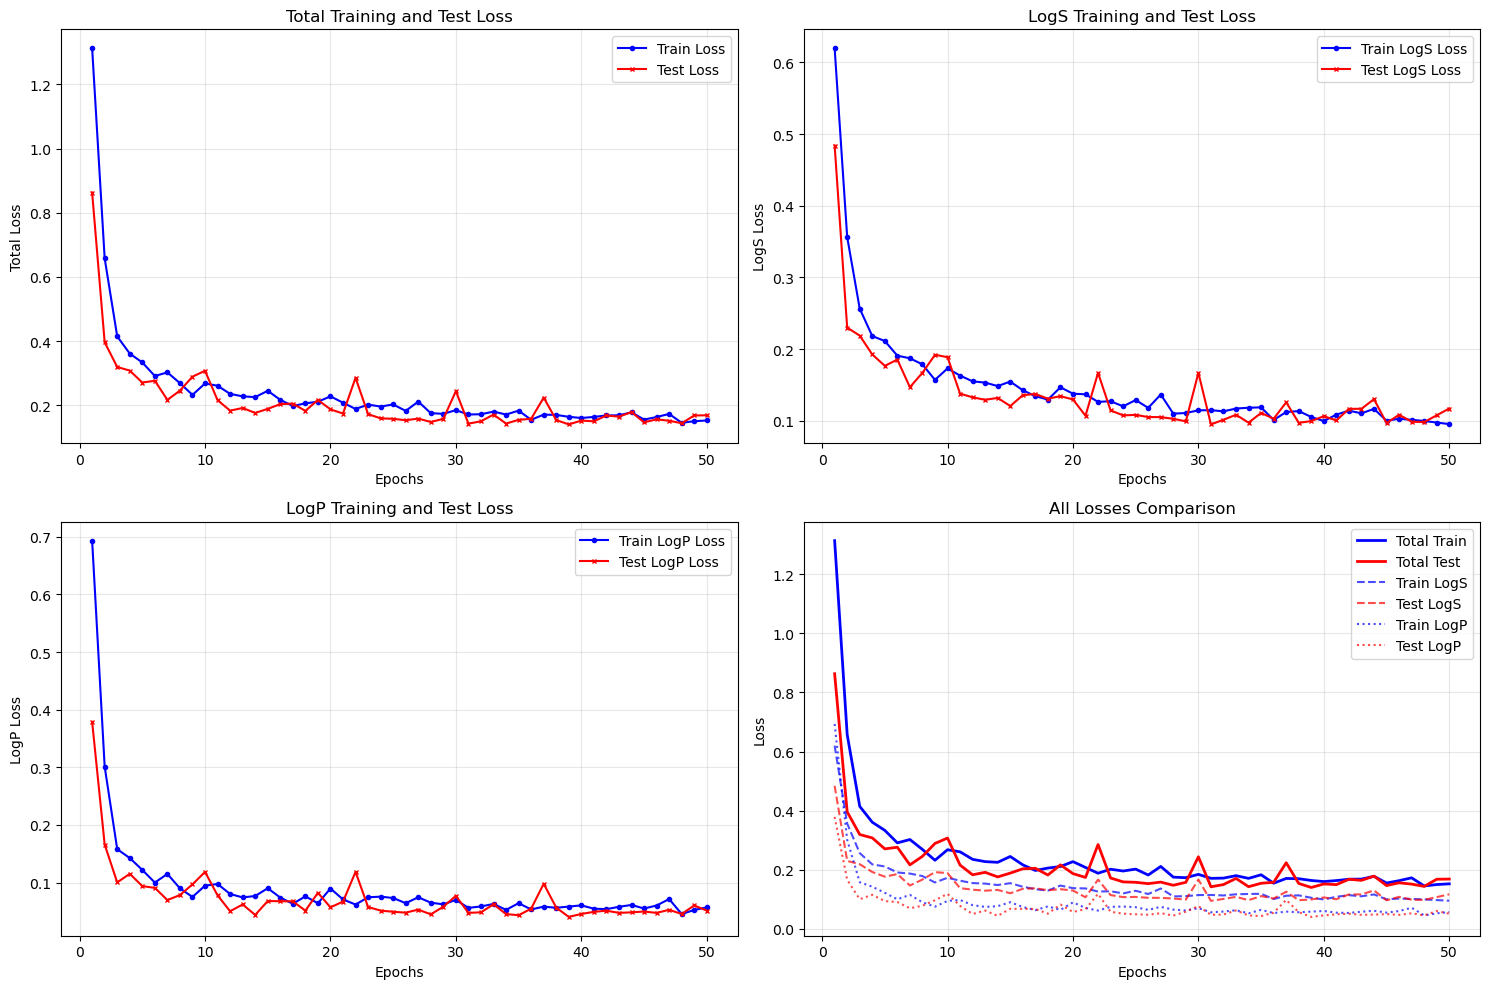

Evaluating best model: 100%|██████████| 225/225 [00:02<00:00, 84.35it/s]


LogS PREDICTION METRICS:
  MSE:  0.4372
  RMSE: 0.6612
  MAE:  0.5030
  R²:   0.9092

LogP PREDICTION METRICS:
  MSE:  0.1391
  RMSE: 0.3729
  MAE:  0.2717
  R²:   0.9610


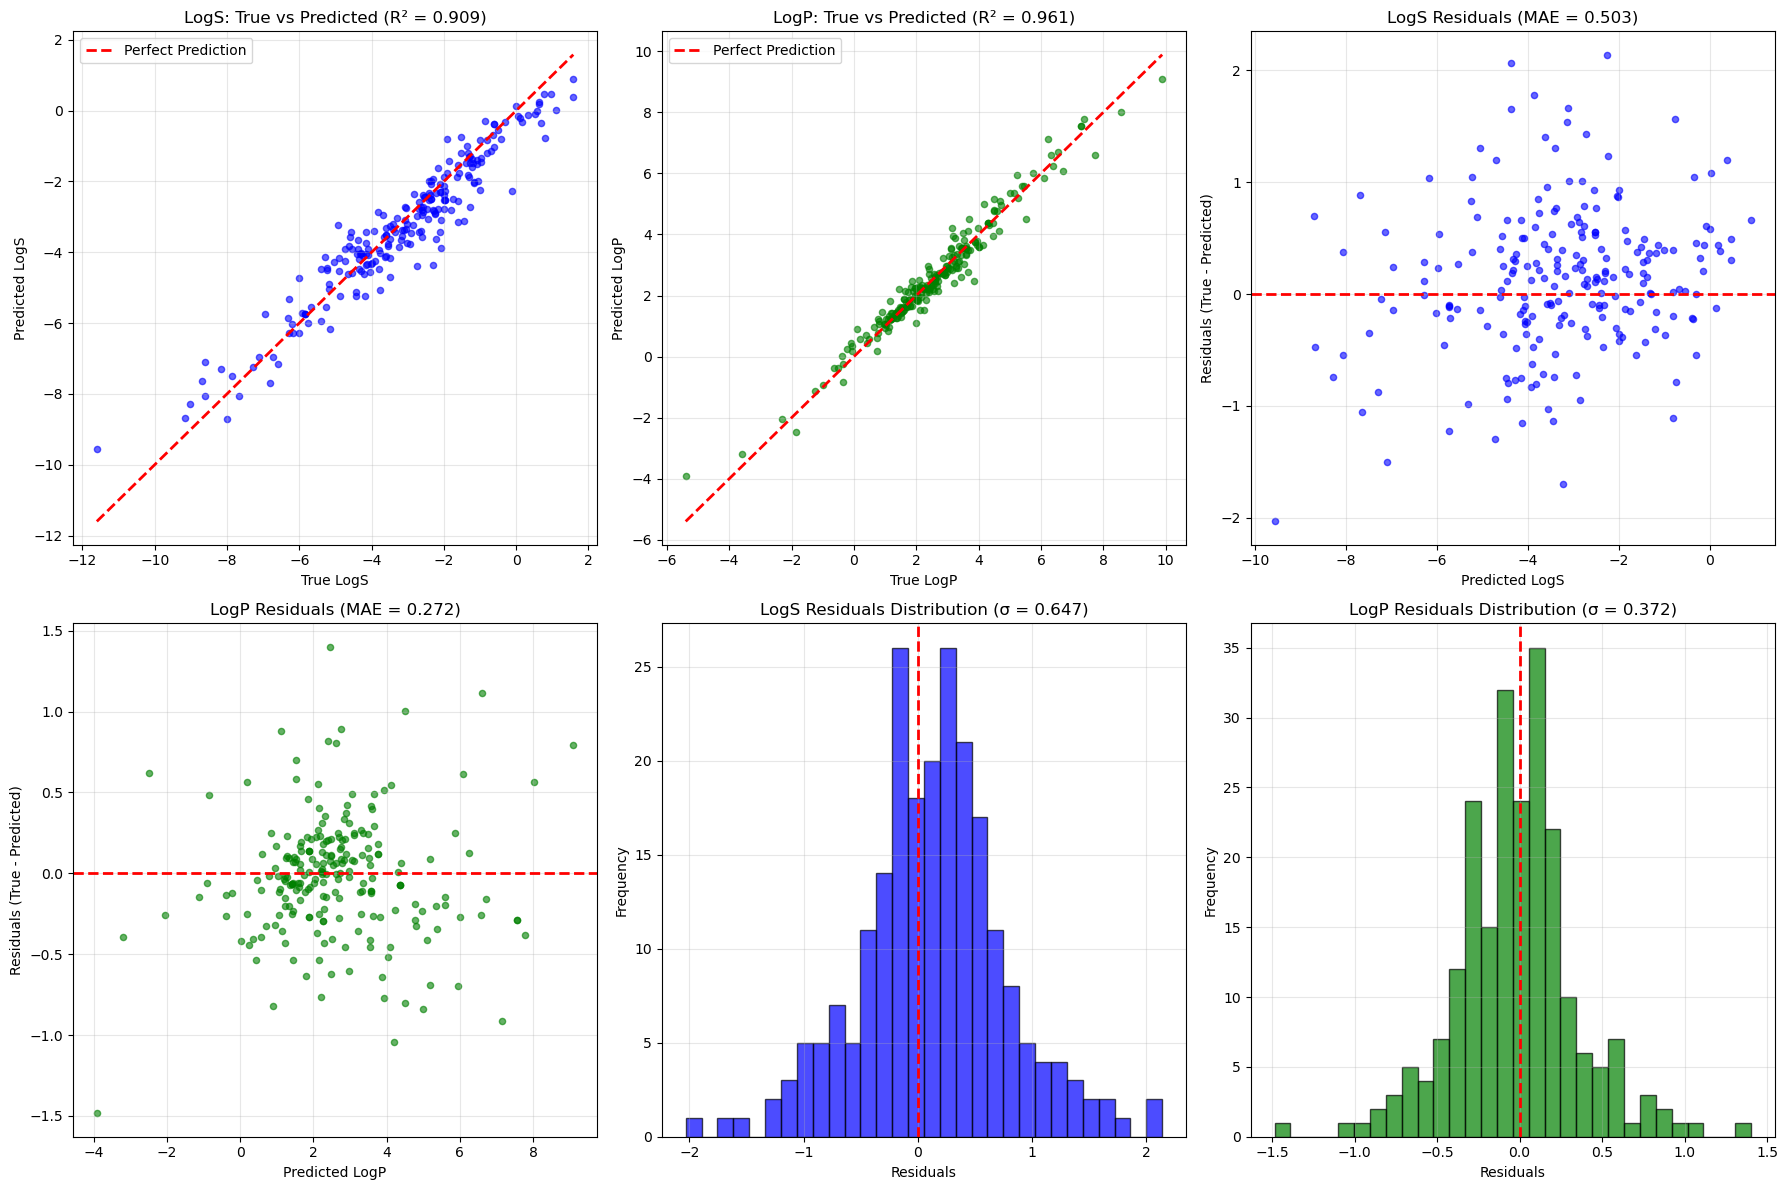

In [32]:
# Plot the results
plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp)
# Evaluate the best model
result_dict=evaluate_best_model(model, 'models/mpnn_edgeconv_model.pt', test_loader, device, scaler_logS=scaler_logS, scaler_logP=scaler_logP)
results_dir['mpnn_edgeconv'] = result_dict

## Comparing Results of Different Models

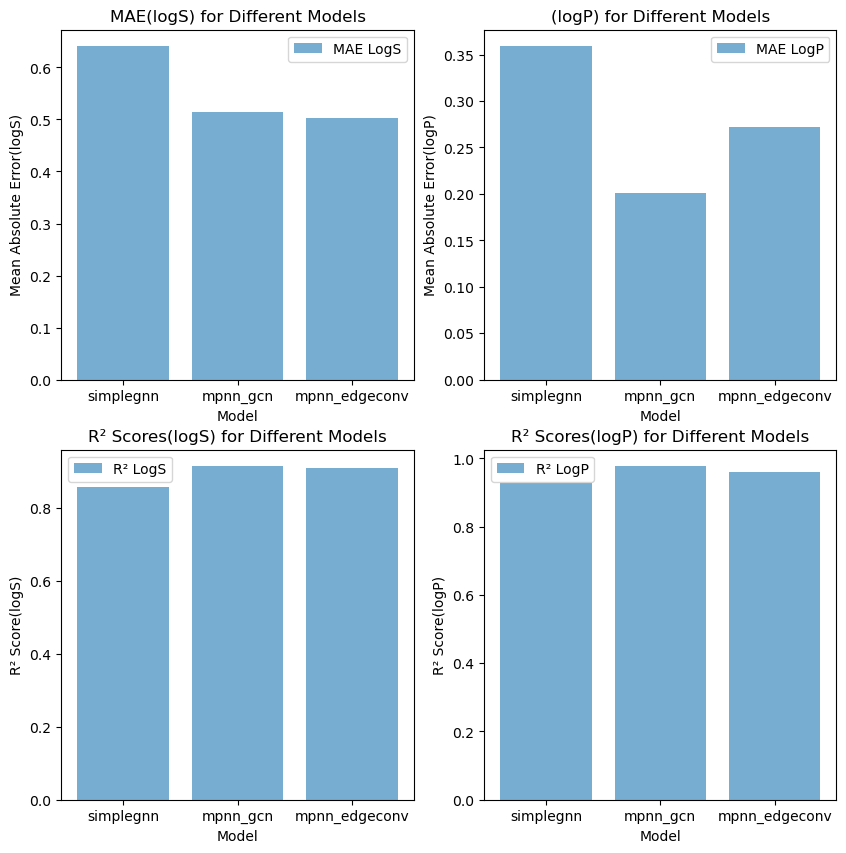

In [33]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.bar(results_dir.keys(), [v['mae_logs'] for v in results_dir.values()], label='MAE LogS', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error(logS)')
plt.title('MAE(logS) for Different Models')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(results_dir.keys(), [v['mae_logp'] for v in results_dir.values()], label='MAE LogP', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error(logP)')
plt.title('(logP) for Different Models')
plt.legend()

plt.subplot(2,2,3)
plt.bar(results_dir.keys(), [v['r2 logs'] for v in results_dir.values()], label='R² LogS', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('R² Score(logS)')
plt.title('R² Scores(logS) for Different Models')
plt.legend()

plt.subplot(2,2,4)
plt.bar(results_dir.keys(), [v['r2 logp'] for v in results_dir.values()], label='R² LogP', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('R² Score(logP)')
plt.title('R² Scores(logP) for Different Models')
plt.legend()

